# Approximating data using deep learning

Note that for this approach we based ourselves on the Standford lecture notes on convolutional neural networks for visual recognition.

This lecture is open source and can be found on http://cs231n.github.io/ 

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2

import gc

import crowd
import experts
import supercrowd as sc

import numpy as np
import math
from PIL import Image
import timeit

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import MaxNorm

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.75

In [3]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err
    
    
def build_poly(X, degree):
    poly = np.ones((len(X), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(X, deg)]
    return poly[:, 1:]

def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def plot_history(history):
    '''
    Plots the history of the training error
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data



In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
################################################################################################
# Careful                                                                                      #
# Normally, normalisation should be done one each train/val/test matrices. It is not done here #
################################################################################################
X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [11]:
# Prepare train and test set

train_set_size = int(len(X) * TRAIN_SET_PERC)
X_train = X[: train_set_size]
X_test = X[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [12]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we want to see how well a single densly connected neural network performs on our data. This neural network will also be our witness for our optimization tasks.

In [14]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Number of layers and neurons doesn't really matter, we need as much as possible.
    # We well take care of overfitting with regularizers.
    # We chose relu activation (relative usual choice when working on regression)
    # We add L2 regularizers on hidden layers to avoid overfitting the data. Threshold should be tuned.
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [15]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 200
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.1
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 24339 samples, validate on 2705 samples
Epoch 1/200
24339/24339 [==============================] - 33s 1ms/step - loss: 16.2263 - mean_absolute_error: 2.3938 - val_loss: 6.2262 - val_mean_absolute_error: 1.8358
Epoch 2/200
24339/24339 [==============================] - 33s 1ms/step - loss: 3.2662 - mean_absolute_error: 1.3039 - val_loss: 4.0006 - val_mean_absolute_error: 1.4015
Epoch 3/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.8035 - mean_absolute_error: 0.9428 - val_loss: 4.2133 - val_mean_absolute_error: 1.4561
Epoch 4/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.7472 - mean_absolute_error: 0.9308 - val_loss: 3.5445 - val_mean_absolute_error: 1.3147
Epoch 5/200
24339/24339 [==============================] - 31s 1ms/step - loss: 1.4083 - mean_absolute_error: 0.8200 - val_loss: 3.1718 - val_mean_absolute_error: 1.2550
Epoch 6/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.9822 - mean_absolu

Epoch 49/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2332 - mean_absolute_error: 0.2662 - val_loss: 0.6181 - val_mean_absolute_error: 0.5156
Epoch 50/200
24339/24339 [==============================] - 32s 1ms/step - loss: 0.2462 - mean_absolute_error: 0.2666 - val_loss: 0.5834 - val_mean_absolute_error: 0.4958
Epoch 51/200
24339/24339 [==============================] - 34s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.2700 - val_loss: 0.6383 - val_mean_absolute_error: 0.5298
Epoch 52/200
24339/24339 [==============================] - 35s 1ms/step - loss: 0.2387 - mean_absolute_error: 0.2609 - val_loss: 0.6260 - val_mean_absolute_error: 0.5193
Epoch 53/200
24339/24339 [==============================] - 33s 1ms/step - loss: 0.2534 - mean_absolute_error: 0.2679 - val_loss: 0.7373 - val_mean_absolute_error: 0.5672
Epoch 54/200
24339/24339 [==============================] - 30s 1ms/step - loss: 0.2392 - mean_absolute_error: 0.2541 - val_loss: 0.6180 - val_me

Epoch 97/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1789 - mean_absolute_error: 0.2405 - val_loss: 0.6396 - val_mean_absolute_error: 0.5494
Epoch 98/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1754 - mean_absolute_error: 0.2384 - val_loss: 0.5826 - val_mean_absolute_error: 0.5109
Epoch 99/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1846 - mean_absolute_error: 0.2464 - val_loss: 0.6068 - val_mean_absolute_error: 0.5251
Epoch 100/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1732 - mean_absolute_error: 0.2346 - val_loss: 0.5752 - val_mean_absolute_error: 0.4983
Epoch 101/200
24339/24339 [==============================] - 31s 1ms/step - loss: 0.1945 - mean_absolute_error: 0.2554 - val_loss: 0.5877 - val_mean_absolute_error: 0.5083
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dens

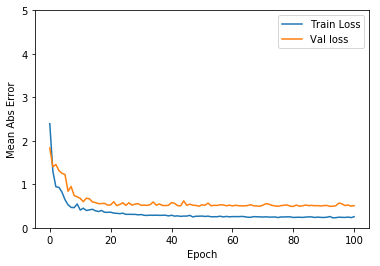

In [16]:
plot_history(history)

In [17]:
result = model.predict(X_test, batch_size=32)
rmse(result, y_test)

0.6604633181447641

## Results [Please update me]

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Early stopping callback
    - Test split of 0.2
    - Using AdamOptimizer gives best results.
    - No cross validation.
    
Network size :
- $4*64 + 1 = 257$ neurons (biases)
- $30049*64 + 64*64 + 64*64 + 64 = 1931392$ weights
- Total of $1931649$ learnable parameters (almost 2 millions)

With the above, we reached a RMSE of 0.5. But this is without separating the data into train and test set. This can lead to overfitting. Now we need to ensure that we are not overfitting.

# Crowd of Neural Networks Approach

Now we try a new approach based on the *Wisdom Of Crowds* principle which states that the average of the predictions of a crowd is almost always better than the prediction of a single expert.

Hence we will create a Crowd composed of a multitude of experts, train them all on the same training set and then ask them all to predict the test data. We will then average their predictions to give the final answer of the crowd, counting on the randomness of the neural network algorithm to give different answers for each individual, needed assumption for the principle to hold.

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [6]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

In [7]:
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [ ]:
crowd01 = crowd.Crowd(X_train_red, y_train, "DNN_Crowd")
crowd01.restore()

In [9]:
crowd01.train_new_entities(8)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20000/20282 [============================>.] - ETA: 0s - loss: 31.7270 - mean_absolute_error: 3.0263
Epoch 00001: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 207us/step - loss: 31.4746 - mean_absolute_error: 3.0093 - val_loss: 13.8795 - val_mean_absolute_error: 1.7699
Epoch 2/200
20128/20282 [============================>.] - ETA: 0s - loss: 11.9335 - mean_absolute_error: 1.5997
Epoch 00002: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 177us/step - loss: 11.9072 - mean_absolute_error: 1.5954 - val_loss: 9.6185 - val_mean_absolute_error: 1.2785
Epoch 3/200
20224/20282 [============================>.] - ETA: 0s - loss: 7.7107 - mean_absolute_error: 0.9397
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 194us/step - l

20282/20282 [==============================] - 4s 178us/step - loss: 0.7459 - mean_absolute_error: 0.4270 - val_loss: 0.8983 - val_mean_absolute_error: 0.4864
Epoch 25/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7864 - mean_absolute_error: 0.4519
Epoch 00025: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 173us/step - loss: 0.7863 - mean_absolute_error: 0.4520 - val_loss: 1.1304 - val_mean_absolute_error: 0.6567
Epoch 26/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.7316 - mean_absolute_error: 0.4306
Epoch 00026: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 173us/step - loss: 0.7310 - mean_absolute_error: 0.4304 - val_loss: 0.8046 - val_mean_absolute_error: 0.4729
Epoch 27/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6920 - mean_absolute_error: 0.4228
Epoch 00027: saving model to ses

Epoch 72/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5434 - mean_absolute_error: 0.3968
Epoch 00072: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 187us/step - loss: 0.5447 - mean_absolute_error: 0.3974 - val_loss: 0.6299 - val_mean_absolute_error: 0.4292
Epoch 73/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5067 - mean_absolute_error: 0.3729
Epoch 00073: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 184us/step - loss: 0.5068 - mean_absolute_error: 0.3730 - val_loss: 0.5901 - val_mean_absolute_error: 0.4114
Epoch 74/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5332 - mean_absolute_error: 0.3897
Epoch 00074: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/16
20282/20282 [==============================] - 4s 178us/step - loss: 0.5340 - mean_absolute_error: 0.3905 - val_los

Epoch 3/200
20096/20282 [============================>.] - ETA: 0s - loss: 7.0411 - mean_absolute_error: 0.7867
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 191us/step - loss: 7.0323 - mean_absolute_error: 0.7858 - val_loss: 6.2038 - val_mean_absolute_error: 0.7172
Epoch 4/200
20160/20282 [============================>.] - ETA: 0s - loss: 5.2288 - mean_absolute_error: 0.5395
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 181us/step - loss: 5.2246 - mean_absolute_error: 0.5390 - val_loss: 4.8803 - val_mean_absolute_error: 0.6048
Epoch 5/200
20096/20282 [============================>.] - ETA: 0s - loss: 4.2745 - mean_absolute_error: 0.5611
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 189us/step - loss: 4.2708 - mean_absolute_error: 0.5609 - val_loss: 

Epoch 27/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6969 - mean_absolute_error: 0.4269
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 188us/step - loss: 0.6968 - mean_absolute_error: 0.4268 - val_loss: 0.8671 - val_mean_absolute_error: 0.5058
Epoch 28/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6758 - mean_absolute_error: 0.4204
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 185us/step - loss: 0.6760 - mean_absolute_error: 0.4205 - val_loss: 0.8145 - val_mean_absolute_error: 0.4754
Epoch 29/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6698 - mean_absolute_error: 0.4190
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 183us/step - loss: 0.6697 - mean_absolute_error: 0.4190 - val_los

Epoch 51/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5518 - mean_absolute_error: 0.3998
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 185us/step - loss: 0.5516 - mean_absolute_error: 0.3997 - val_loss: 0.7422 - val_mean_absolute_error: 0.4946
Epoch 52/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5420 - mean_absolute_error: 0.3926
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 184us/step - loss: 0.5430 - mean_absolute_error: 0.3933 - val_loss: 0.6439 - val_mean_absolute_error: 0.4341
Epoch 53/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5442 - mean_absolute_error: 0.3924
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 186us/step - loss: 0.5444 - mean_absolute_error: 0.3924 - val_los

20282/20282 [==============================] - 4s 184us/step - loss: 0.5088 - mean_absolute_error: 0.3796 - val_loss: 0.6480 - val_mean_absolute_error: 0.4409
Epoch 75/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5166 - mean_absolute_error: 0.3812
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 193us/step - loss: 0.5173 - mean_absolute_error: 0.3814 - val_loss: 0.7498 - val_mean_absolute_error: 0.5118
Epoch 76/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5129 - mean_absolute_error: 0.3817
Epoch 00076: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/17
20282/20282 [==============================] - 4s 185us/step - loss: 0.5134 - mean_absolute_error: 0.3822 - val_loss: 0.6565 - val_mean_absolute_error: 0.4688
Epoch 77/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5074 - mean_absolute_error: 0.3798
Epoch 00077: saving model to ses

Epoch 7/200
20256/20282 [============================>.] - ETA: 0s - loss: 3.1032 - mean_absolute_error: 0.5447
Epoch 00007: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 178us/step - loss: 3.1028 - mean_absolute_error: 0.5448 - val_loss: 2.8670 - val_mean_absolute_error: 0.5482
Epoch 8/200
19968/20282 [============================>.] - ETA: 0s - loss: 2.5636 - mean_absolute_error: 0.5330
Epoch 00008: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 3s 165us/step - loss: 2.5587 - mean_absolute_error: 0.5324 - val_loss: 2.5098 - val_mean_absolute_error: 0.5752
Epoch 9/200
20032/20282 [============================>.] - ETA: 0s - loss: 2.0976 - mean_absolute_error: 0.5020
Epoch 00009: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 3s 172us/step - loss: 2.0961 - mean_absolute_error: 0.5023 - val_loss: 

Epoch 31/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6516 - mean_absolute_error: 0.4081
Epoch 00031: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 179us/step - loss: 0.6518 - mean_absolute_error: 0.4084 - val_loss: 0.7624 - val_mean_absolute_error: 0.4727
Epoch 32/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6170 - mean_absolute_error: 0.4058
Epoch 00032: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 196us/step - loss: 0.6165 - mean_absolute_error: 0.4055 - val_loss: 0.7404 - val_mean_absolute_error: 0.4425
Epoch 33/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6297 - mean_absolute_error: 0.4039
Epoch 00033: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 195us/step - loss: 0.6294 - mean_absolute_error: 0.4037 - val_los

20282/20282 [==============================] - 4s 181us/step - loss: 0.5472 - mean_absolute_error: 0.3871 - val_loss: 0.6682 - val_mean_absolute_error: 0.4368
Epoch 55/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5728 - mean_absolute_error: 0.4049
Epoch 00055: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 173us/step - loss: 0.5747 - mean_absolute_error: 0.4057 - val_loss: 0.6749 - val_mean_absolute_error: 0.4523
Epoch 56/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5425 - mean_absolute_error: 0.3827
Epoch 00056: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/18
20282/20282 [==============================] - 4s 175us/step - loss: 0.5431 - mean_absolute_error: 0.3828 - val_loss: 0.6933 - val_mean_absolute_error: 0.4409
Epoch 57/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5651 - mean_absolute_error: 0.3929
Epoch 00057: saving model to ses

Epoch 21/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.8839 - mean_absolute_error: 0.4585
Epoch 00021: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 184us/step - loss: 0.8838 - mean_absolute_error: 0.4584 - val_loss: 0.9874 - val_mean_absolute_error: 0.4996
Epoch 22/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.8199 - mean_absolute_error: 0.4462
Epoch 00022: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 175us/step - loss: 0.8204 - mean_absolute_error: 0.4467 - val_loss: 0.9048 - val_mean_absolute_error: 0.4841
Epoch 23/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.8105 - mean_absolute_error: 0.4368
Epoch 00023: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 173us/step - loss: 0.8114 - mean_absolute_error: 0.4368 - val_los

Epoch 45/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5873 - mean_absolute_error: 0.4081
Epoch 00045: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 186us/step - loss: 0.5872 - mean_absolute_error: 0.4083 - val_loss: 0.6572 - val_mean_absolute_error: 0.4301
Epoch 46/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5338 - mean_absolute_error: 0.3804
Epoch 00046: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 182us/step - loss: 0.5345 - mean_absolute_error: 0.3806 - val_loss: 0.7162 - val_mean_absolute_error: 0.4925
Epoch 47/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5481 - mean_absolute_error: 0.3885
Epoch 00047: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 183us/step - loss: 0.5491 - mean_absolute_error: 0.3894 - val_los

Epoch 69/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5057 - mean_absolute_error: 0.3748
Epoch 00069: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 177us/step - loss: 0.5058 - mean_absolute_error: 0.3745 - val_loss: 0.6108 - val_mean_absolute_error: 0.4190
Epoch 70/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5113 - mean_absolute_error: 0.3817
Epoch 00070: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 176us/step - loss: 0.5117 - mean_absolute_error: 0.3821 - val_loss: 0.5986 - val_mean_absolute_error: 0.4220
Epoch 71/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5082 - mean_absolute_error: 0.3771
Epoch 00071: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/19
20282/20282 [==============================] - 4s 177us/step - loss: 0.5084 - mean_absolute_error: 0.3772 - val_los

Epoch 3/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.2102 - mean_absolute_error: 0.4211
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 180us/step - loss: 1.2103 - mean_absolute_error: 0.4217 - val_loss: 1.2627 - val_mean_absolute_error: 0.4913
Epoch 4/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.0502 - mean_absolute_error: 0.4049
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 178us/step - loss: 1.0498 - mean_absolute_error: 0.4049 - val_loss: 1.2416 - val_mean_absolute_error: 0.5576
Epoch 5/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.9603 - mean_absolute_error: 0.4278
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 180us/step - loss: 0.9616 - mean_absolute_error: 0.4285 - val_loss: 

Epoch 27/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6993 - mean_absolute_error: 0.4403
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 175us/step - loss: 0.7001 - mean_absolute_error: 0.4407 - val_loss: 0.7698 - val_mean_absolute_error: 0.4697
Epoch 28/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6537 - mean_absolute_error: 0.4204
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 180us/step - loss: 0.6537 - mean_absolute_error: 0.4206 - val_loss: 0.8463 - val_mean_absolute_error: 0.5281
Epoch 29/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6757 - mean_absolute_error: 0.4218
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 178us/step - loss: 0.6755 - mean_absolute_error: 0.4217 - val_los

Epoch 51/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5647 - mean_absolute_error: 0.4021
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 202us/step - loss: 0.5643 - mean_absolute_error: 0.4017 - val_loss: 0.6555 - val_mean_absolute_error: 0.4351
Epoch 52/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5865 - mean_absolute_error: 0.4157
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 184us/step - loss: 0.5862 - mean_absolute_error: 0.4155 - val_loss: 0.6463 - val_mean_absolute_error: 0.4245
Epoch 53/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5630 - mean_absolute_error: 0.3978
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/20
20282/20282 [==============================] - 4s 197us/step - loss: 0.5634 - mean_absolute_error: 0.3981 - val_los

Epoch 3/200
20096/20282 [============================>.] - ETA: 0s - loss: 7.8518 - mean_absolute_error: 0.9009
Epoch 00003: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 200us/step - loss: 7.8380 - mean_absolute_error: 0.8988 - val_loss: 6.6000 - val_mean_absolute_error: 0.7427
Epoch 4/200
20256/20282 [============================>.] - ETA: 0s - loss: 5.5940 - mean_absolute_error: 0.5602
Epoch 00004: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 194us/step - loss: 5.5931 - mean_absolute_error: 0.5601 - val_loss: 5.2421 - val_mean_absolute_error: 0.6172
Epoch 5/200
20192/20282 [============================>.] - ETA: 0s - loss: 4.5227 - mean_absolute_error: 0.5306
Epoch 00005: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 213us/step - loss: 4.5210 - mean_absolute_error: 0.5307 - val_loss: 

Epoch 27/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7616 - mean_absolute_error: 0.4387
Epoch 00027: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 191us/step - loss: 0.7611 - mean_absolute_error: 0.4384 - val_loss: 0.8532 - val_mean_absolute_error: 0.4718
Epoch 28/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.7006 - mean_absolute_error: 0.4100
Epoch 00028: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 182us/step - loss: 0.7002 - mean_absolute_error: 0.4098 - val_loss: 0.8481 - val_mean_absolute_error: 0.5012
Epoch 29/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7092 - mean_absolute_error: 0.4332
Epoch 00029: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 203us/step - loss: 0.7091 - mean_absolute_error: 0.4331 - val_los

Epoch 51/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5552 - mean_absolute_error: 0.3934
Epoch 00051: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 181us/step - loss: 0.5551 - mean_absolute_error: 0.3933 - val_loss: 0.6331 - val_mean_absolute_error: 0.4244
Epoch 52/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5493 - mean_absolute_error: 0.3916
Epoch 00052: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 181us/step - loss: 0.5494 - mean_absolute_error: 0.3916 - val_loss: 0.6651 - val_mean_absolute_error: 0.4310
Epoch 53/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5362 - mean_absolute_error: 0.3866
Epoch 00053: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 181us/step - loss: 0.5367 - mean_absolute_error: 0.3868 - val_los

Epoch 75/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5251 - mean_absolute_error: 0.3887
Epoch 00075: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 185us/step - loss: 0.5253 - mean_absolute_error: 0.3888 - val_loss: 0.6600 - val_mean_absolute_error: 0.4667
Epoch 76/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5039 - mean_absolute_error: 0.3789
Epoch 00076: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 190us/step - loss: 0.5042 - mean_absolute_error: 0.3789 - val_loss: 0.6585 - val_mean_absolute_error: 0.4562
Epoch 77/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5006 - mean_absolute_error: 0.3725
Epoch 00077: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 187us/step - loss: 0.5001 - mean_absolute_error: 0.3721 - val_los

Epoch 99/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.4824 - mean_absolute_error: 0.3684
Epoch 00099: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 188us/step - loss: 0.4822 - mean_absolute_error: 0.3684 - val_loss: 0.6268 - val_mean_absolute_error: 0.4361
Epoch 100/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.4977 - mean_absolute_error: 0.3792
Epoch 00100: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 202us/step - loss: 0.4976 - mean_absolute_error: 0.3792 - val_loss: 0.6245 - val_mean_absolute_error: 0.4379
Epoch 101/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.4867 - mean_absolute_error: 0.3731
Epoch 00101: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/21
20282/20282 [==============================] - 4s 205us/step - loss: 0.4873 - mean_absolute_error: 0.3734 - val_l

Epoch 10/200
20256/20282 [============================>.] - ETA: 0s - loss: 1.6859 - mean_absolute_error: 0.5140
Epoch 00010: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 5s 235us/step - loss: 1.6857 - mean_absolute_error: 0.5140 - val_loss: 1.6912 - val_mean_absolute_error: 0.5458
Epoch 11/200
20256/20282 [============================>.] - ETA: 0s - loss: 1.4527 - mean_absolute_error: 0.5029
Epoch 00011: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 217us/step - loss: 1.4526 - mean_absolute_error: 0.5030 - val_loss: 1.4622 - val_mean_absolute_error: 0.5432
Epoch 12/200
20192/20282 [============================>.] - ETA: 0s - loss: 1.3042 - mean_absolute_error: 0.5043
Epoch 00012: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 220us/step - loss: 1.3053 - mean_absolute_error: 0.5050 - val_los

Epoch 34/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6243 - mean_absolute_error: 0.4211
Epoch 00034: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 194us/step - loss: 0.6246 - mean_absolute_error: 0.4213 - val_loss: 0.7069 - val_mean_absolute_error: 0.4411
Epoch 35/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6434 - mean_absolute_error: 0.4187
Epoch 00035: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 200us/step - loss: 0.6429 - mean_absolute_error: 0.4185 - val_loss: 0.7347 - val_mean_absolute_error: 0.4532
Epoch 36/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5741 - mean_absolute_error: 0.3890
Epoch 00036: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 202us/step - loss: 0.5741 - mean_absolute_error: 0.3892 - val_los

Epoch 58/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5277 - mean_absolute_error: 0.3809
Epoch 00058: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 202us/step - loss: 0.5275 - mean_absolute_error: 0.3808 - val_loss: 0.6472 - val_mean_absolute_error: 0.4484
Epoch 59/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5384 - mean_absolute_error: 0.3947
Epoch 00059: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 193us/step - loss: 0.5382 - mean_absolute_error: 0.3946 - val_loss: 0.6662 - val_mean_absolute_error: 0.4534
Epoch 60/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5325 - mean_absolute_error: 0.3925
Epoch 00060: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/22
20282/20282 [==============================] - 4s 202us/step - loss: 0.5329 - mean_absolute_error: 0.3927 - val_los

Epoch 7/200
20032/20282 [============================>.] - ETA: 0s - loss: 2.7022 - mean_absolute_error: 0.5148
Epoch 00007: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 203us/step - loss: 2.6988 - mean_absolute_error: 0.5146 - val_loss: 2.6789 - val_mean_absolute_error: 0.5702
Epoch 8/200
20128/20282 [============================>.] - ETA: 0s - loss: 2.2263 - mean_absolute_error: 0.4993
Epoch 00008: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 204us/step - loss: 2.2252 - mean_absolute_error: 0.4997 - val_loss: 2.1976 - val_mean_absolute_error: 0.5516
Epoch 9/200
20224/20282 [============================>.] - ETA: 0s - loss: 2.0524 - mean_absolute_error: 0.5754
Epoch 00009: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 216us/step - loss: 2.0514 - mean_absolute_error: 0.5751 - val_loss: 

Epoch 31/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6933 - mean_absolute_error: 0.4136
Epoch 00031: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 205us/step - loss: 0.6939 - mean_absolute_error: 0.4141 - val_loss: 0.9112 - val_mean_absolute_error: 0.5395
Epoch 32/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6857 - mean_absolute_error: 0.4210
Epoch 00032: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 203us/step - loss: 0.6857 - mean_absolute_error: 0.4211 - val_loss: 0.8563 - val_mean_absolute_error: 0.5095
Epoch 33/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6638 - mean_absolute_error: 0.4180
Epoch 00033: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 207us/step - loss: 0.6661 - mean_absolute_error: 0.4195 - val_los

Epoch 55/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5522 - mean_absolute_error: 0.3888
Epoch 00055: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 193us/step - loss: 0.5524 - mean_absolute_error: 0.3888 - val_loss: 0.6732 - val_mean_absolute_error: 0.4691
Epoch 56/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5538 - mean_absolute_error: 0.3922
Epoch 00056: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 195us/step - loss: 0.5538 - mean_absolute_error: 0.3922 - val_loss: 0.6462 - val_mean_absolute_error: 0.4354
Epoch 57/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5337 - mean_absolute_error: 0.3810
Epoch 00057: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 193us/step - loss: 0.5330 - mean_absolute_error: 0.3805 - val_los

Epoch 79/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5221 - mean_absolute_error: 0.3793
Epoch 00079: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 212us/step - loss: 0.5218 - mean_absolute_error: 0.3792 - val_loss: 0.7127 - val_mean_absolute_error: 0.5090
Epoch 80/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5332 - mean_absolute_error: 0.3906
Epoch 00080: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 201us/step - loss: 0.5350 - mean_absolute_error: 0.3916 - val_loss: 0.7157 - val_mean_absolute_error: 0.5095
Epoch 81/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5232 - mean_absolute_error: 0.3876
Epoch 00081: saving model to session/DNN_Crowd_8_128_relu_0.01_0.001_mse/23
20282/20282 [==============================] - 4s 202us/step - loss: 0.5230 - mean_absolute_error: 0.3874 - val_los

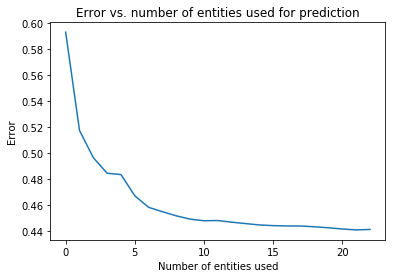

In [10]:
crowd01.plot_crowd_error(X_test_red, y_test, rmse)

## Conclusion

Looking at the error versus the number of networks used for prediction, the results is undeniable : the crowd definetely reduce our error in an impressive way.

We wish to see how the error is distributed among the different networks. If this distribution is zero-meaned, this would mean that we can continue to add more and more networks until reaching an error as low as we want. Also we wish to know if the assumption that the error is gaussianly distributed is a reasonable assumption.

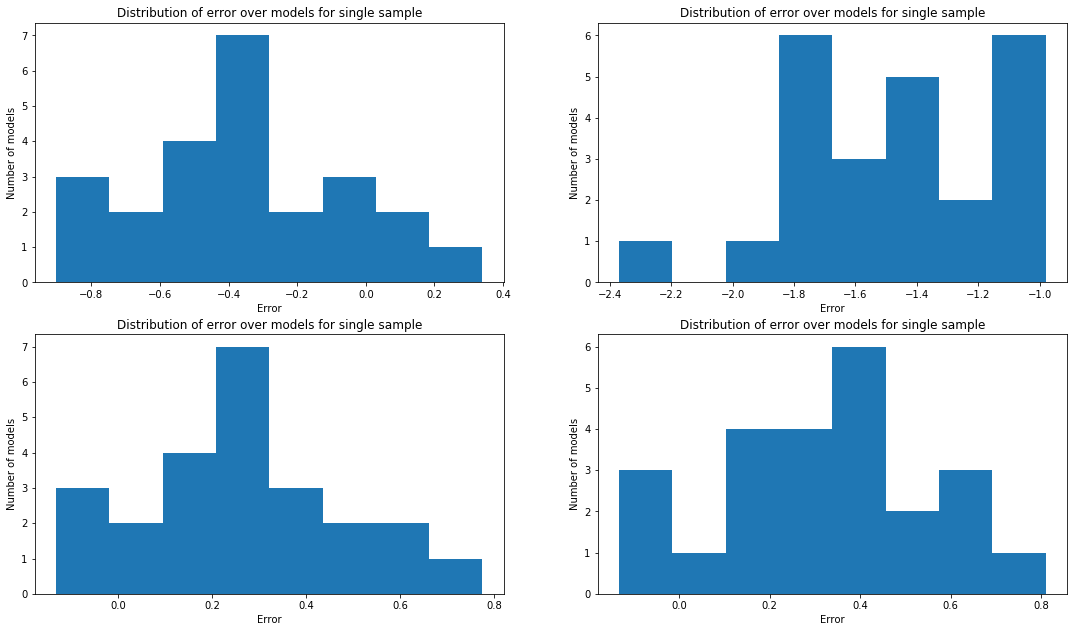

In [11]:
nb_bins = 8

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.subplot(221)
crowd01.plot_error_dist_on_sample(X_test_red[0], y_test[0], basic_error, show = False, bins = nb_bins)
plt.subplot(222)
crowd01.plot_error_dist_on_sample(X_test_red[1], y_test[1], basic_error, show = False, bins = nb_bins)
plt.subplot(223)
crowd01.plot_error_dist_on_sample(X_test_red[2], y_test[2], basic_error, show = False, bins = nb_bins)
plt.subplot(224)
crowd01.plot_error_dist_on_sample(X_test_red[3], y_test[3], basic_error, show = False, bins = nb_bins)
plt.show()

In [12]:
rmse(crowd01.predict(X_test_red), y_test)

0.44112549351712965

In [9]:
crowd02 = crowd.Crowd(X_train_red, y_train, "Crowd02", nb_layers = 16, nb_neurons=64)
crowd02.restore()

Recovered 8 entities from session/Crowd02_16_64_relu_0.01_0.001_mse/8


In [15]:
crowd02.train_new_entities(8)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20192/20282 [============================>.] - ETA: 0s - loss: 33.5640 - mean_absolute_error: 2.9060
Epoch 00001: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 8s 404us/step - loss: 33.4502 - mean_absolute_error: 2.8979 - val_loss: 8.0761 - val_mean_absolute_error: 1.1117
Epoch 2/200
20256/20282 [============================>.] - ETA: 0s - loss: 6.6572 - mean_absolute_error: 0.8061
Epoch 00002: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 203us/step - loss: 6.6557 - mean_absolute_error: 0.8058 - val_loss: 6.5345 - val_mean_absolute_error: 0.9138
Epoch 3/200
20064/20282 [============================>.] - ETA: 0s - loss: 5.3287 - mean_absolute_error: 0.5496
Epoch 00003: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 199us/step - loss: 5.3263 

Epoch 25/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.0055 - mean_absolute_error: 0.4627
Epoch 00025: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 202us/step - loss: 1.0065 - mean_absolute_error: 0.4634 - val_loss: 1.2804 - val_mean_absolute_error: 0.6241
Epoch 26/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.9561 - mean_absolute_error: 0.4497
Epoch 00026: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.9565 - mean_absolute_error: 0.4497 - val_loss: 1.3594 - val_mean_absolute_error: 0.6943
Epoch 27/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.9845 - mean_absolute_error: 0.4732
Epoch 00027: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 211us/step - loss: 0.9856 - mean_absolute_error: 0.4735 - val_loss: 1.1484

Epoch 49/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7651 - mean_absolute_error: 0.4493
Epoch 00049: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 191us/step - loss: 0.7645 - mean_absolute_error: 0.4488 - val_loss: 0.7786 - val_mean_absolute_error: 0.4346
Epoch 50/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6917 - mean_absolute_error: 0.4036
Epoch 00050: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 196us/step - loss: 0.6924 - mean_absolute_error: 0.4039 - val_loss: 0.8114 - val_mean_absolute_error: 0.4509
Epoch 51/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7598 - mean_absolute_error: 0.4450
Epoch 00051: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 190us/step - loss: 0.7599 - mean_absolute_error: 0.4451 - val_loss: 0.8477

Epoch 73/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6686 - mean_absolute_error: 0.4123
Epoch 00073: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.6688 - mean_absolute_error: 0.4124 - val_loss: 0.8928 - val_mean_absolute_error: 0.5662
Epoch 74/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6560 - mean_absolute_error: 0.4003
Epoch 00074: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 192us/step - loss: 0.6561 - mean_absolute_error: 0.4003 - val_loss: 0.7723 - val_mean_absolute_error: 0.4514
Epoch 75/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6458 - mean_absolute_error: 0.3916
Epoch 00075: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 209us/step - loss: 0.6463 - mean_absolute_error: 0.3921 - val_loss: 0.7729

Epoch 97/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6170 - mean_absolute_error: 0.3881
Epoch 00097: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 191us/step - loss: 0.6177 - mean_absolute_error: 0.3887 - val_loss: 0.7709 - val_mean_absolute_error: 0.4478
Epoch 98/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6386 - mean_absolute_error: 0.4027
Epoch 00098: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.6388 - mean_absolute_error: 0.4030 - val_loss: 0.7600 - val_mean_absolute_error: 0.4630
Epoch 99/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6269 - mean_absolute_error: 0.3942
Epoch 00099: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 194us/step - loss: 0.6271 - mean_absolute_error: 0.3943 - val_loss: 0.8830

Epoch 121/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6117 - mean_absolute_error: 0.3874
Epoch 00121: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 196us/step - loss: 0.6126 - mean_absolute_error: 0.3880 - val_loss: 0.7450 - val_mean_absolute_error: 0.4565
Epoch 122/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6154 - mean_absolute_error: 0.3963
Epoch 00122: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 196us/step - loss: 0.6160 - mean_absolute_error: 0.3968 - val_loss: 0.7950 - val_mean_absolute_error: 0.4989
Epoch 123/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6068 - mean_absolute_error: 0.3895
Epoch 00123: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 198us/step - loss: 0.6065 - mean_absolute_error: 0.3893 - val_loss: 0.7

Epoch 145/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6188 - mean_absolute_error: 0.3954
Epoch 00145: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 182us/step - loss: 0.6185 - mean_absolute_error: 0.3954 - val_loss: 0.6922 - val_mean_absolute_error: 0.4278
Epoch 146/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5891 - mean_absolute_error: 0.3783
Epoch 00146: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 3s 172us/step - loss: 0.5888 - mean_absolute_error: 0.3781 - val_loss: 0.7028 - val_mean_absolute_error: 0.4329
Epoch 147/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5916 - mean_absolute_error: 0.3829
Epoch 00147: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 173us/step - loss: 0.5919 - mean_absolute_error: 0.3828 - val_loss: 0.7

Epoch 169/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5775 - mean_absolute_error: 0.3741
Epoch 00169: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 178us/step - loss: 0.5776 - mean_absolute_error: 0.3741 - val_loss: 0.6644 - val_mean_absolute_error: 0.4111
Epoch 170/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6003 - mean_absolute_error: 0.3897
Epoch 00170: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 180us/step - loss: 0.6006 - mean_absolute_error: 0.3902 - val_loss: 0.7723 - val_mean_absolute_error: 0.4950
Epoch 171/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5892 - mean_absolute_error: 0.3834
Epoch 00171: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/0
20282/20282 [==============================] - 4s 199us/step - loss: 0.5894 - mean_absolute_error: 0.3837 - val_loss: 0.6

Epoch 20/200
20000/20282 [============================>.] - ETA: 0s - loss: 1.3402 - mean_absolute_error: 0.4921
Epoch 00020: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 186us/step - loss: 1.3414 - mean_absolute_error: 0.4921 - val_loss: 1.4472 - val_mean_absolute_error: 0.5176
Epoch 21/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.3992 - mean_absolute_error: 0.5147
Epoch 00021: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 186us/step - loss: 1.3995 - mean_absolute_error: 0.5147 - val_loss: 1.4533 - val_mean_absolute_error: 0.5349
Epoch 22/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.2277 - mean_absolute_error: 0.4754
Epoch 00022: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 183us/step - loss: 1.2266 - mean_absolute_error: 0.4748 - val_loss: 1.2674

Epoch 44/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7904 - mean_absolute_error: 0.4316
Epoch 00044: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 190us/step - loss: 0.7903 - mean_absolute_error: 0.4315 - val_loss: 0.9481 - val_mean_absolute_error: 0.5203
Epoch 45/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7746 - mean_absolute_error: 0.4312
Epoch 00045: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 188us/step - loss: 0.7749 - mean_absolute_error: 0.4314 - val_loss: 0.9216 - val_mean_absolute_error: 0.4834
Epoch 46/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.7901 - mean_absolute_error: 0.4350
Epoch 00046: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 178us/step - loss: 0.7937 - mean_absolute_error: 0.4373 - val_loss: 1.1531

Epoch 68/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6969 - mean_absolute_error: 0.4139
Epoch 00068: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 200us/step - loss: 0.6974 - mean_absolute_error: 0.4143 - val_loss: 0.9426 - val_mean_absolute_error: 0.5646
Epoch 69/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6719 - mean_absolute_error: 0.4028
Epoch 00069: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 188us/step - loss: 0.6721 - mean_absolute_error: 0.4030 - val_loss: 0.9891 - val_mean_absolute_error: 0.6293
Epoch 70/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6864 - mean_absolute_error: 0.4199
Epoch 00070: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 192us/step - loss: 0.6876 - mean_absolute_error: 0.4206 - val_loss: 0.9754

Epoch 92/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6509 - mean_absolute_error: 0.4023
Epoch 00092: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/1
20282/20282 [==============================] - 4s 181us/step - loss: 0.6521 - mean_absolute_error: 0.4031 - val_loss: 0.9448 - val_mean_absolute_error: 0.5692
Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20032/20282 [============================>.] - ETA: 0s - loss: 37.2664 - mean_absolute_error: 3.1640
Epoch 00001: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 9s 435us/step - loss: 36.9104 - mean_absolute_error: 3.1399 - val_loss: 7.9441 - val_mean_absolute_error: 1.1907
Epoch 2/200
20224/20282 [============================>.] - ETA: 0s - loss: 6.3155 - mean_absolute_error: 0.8329
Epoch 00002: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 196us/step - loss: 6.3132

Epoch 24/200
20192/20282 [============================>.] - ETA: 0s - loss: 1.0212 - mean_absolute_error: 0.4758
Epoch 00024: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 199us/step - loss: 1.0215 - mean_absolute_error: 0.4762 - val_loss: 1.2107 - val_mean_absolute_error: 0.5994
Epoch 25/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.9277 - mean_absolute_error: 0.4463
Epoch 00025: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 193us/step - loss: 0.9273 - mean_absolute_error: 0.4460 - val_loss: 0.9422 - val_mean_absolute_error: 0.4499
Epoch 26/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.9071 - mean_absolute_error: 0.4449
Epoch 00026: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 191us/step - loss: 0.9070 - mean_absolute_error: 0.4448 - val_loss: 1.1419

Epoch 48/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7175 - mean_absolute_error: 0.4179
Epoch 00048: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 203us/step - loss: 0.7196 - mean_absolute_error: 0.4194 - val_loss: 1.1940 - val_mean_absolute_error: 0.7119
Epoch 49/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6923 - mean_absolute_error: 0.4020
Epoch 00049: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 198us/step - loss: 0.6939 - mean_absolute_error: 0.4032 - val_loss: 0.9222 - val_mean_absolute_error: 0.5494
Epoch 50/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7234 - mean_absolute_error: 0.4213
Epoch 00050: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 199us/step - loss: 0.7246 - mean_absolute_error: 0.4223 - val_loss: 0.8702

Epoch 72/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.6611 - mean_absolute_error: 0.3997
Epoch 00072: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 187us/step - loss: 0.6627 - mean_absolute_error: 0.4008 - val_loss: 0.9053 - val_mean_absolute_error: 0.5573
Epoch 73/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.6792 - mean_absolute_error: 0.4170
Epoch 00073: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 186us/step - loss: 0.6817 - mean_absolute_error: 0.4186 - val_loss: 0.7594 - val_mean_absolute_error: 0.4438
Epoch 74/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6561 - mean_absolute_error: 0.4005
Epoch 00074: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 191us/step - loss: 0.6562 - mean_absolute_error: 0.4006 - val_loss: 0.7295

Epoch 96/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6247 - mean_absolute_error: 0.3915
Epoch 00096: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 189us/step - loss: 0.6249 - mean_absolute_error: 0.3916 - val_loss: 0.7220 - val_mean_absolute_error: 0.4400
Epoch 97/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6437 - mean_absolute_error: 0.3983
Epoch 00097: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 201us/step - loss: 0.6436 - mean_absolute_error: 0.3983 - val_loss: 0.7299 - val_mean_absolute_error: 0.4352
Epoch 98/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6463 - mean_absolute_error: 0.4038
Epoch 00098: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 198us/step - loss: 0.6462 - mean_absolute_error: 0.4037 - val_loss: 0.7274

Epoch 120/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6164 - mean_absolute_error: 0.3852
Epoch 00120: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 198us/step - loss: 0.6168 - mean_absolute_error: 0.3858 - val_loss: 0.7079 - val_mean_absolute_error: 0.4296
Epoch 121/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6086 - mean_absolute_error: 0.3885
Epoch 00121: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 195us/step - loss: 0.6091 - mean_absolute_error: 0.3886 - val_loss: 0.7167 - val_mean_absolute_error: 0.4406
Epoch 122/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6092 - mean_absolute_error: 0.3882
Epoch 00122: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/2
20282/20282 [==============================] - 4s 202us/step - loss: 0.6094 - mean_absolute_error: 0.3883 - val_loss: 0.8

Epoch 15/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.4715 - mean_absolute_error: 0.5181
Epoch 00015: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 204us/step - loss: 1.4709 - mean_absolute_error: 0.5175 - val_loss: 1.5141 - val_mean_absolute_error: 0.5472
Epoch 16/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.4543 - mean_absolute_error: 0.5411
Epoch 00016: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 203us/step - loss: 1.4547 - mean_absolute_error: 0.5415 - val_loss: 1.4765 - val_mean_absolute_error: 0.5507
Epoch 17/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.3452 - mean_absolute_error: 0.5071
Epoch 00017: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 204us/step - loss: 1.3451 - mean_absolute_error: 0.5066 - val_loss: 1.3807

Epoch 39/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7732 - mean_absolute_error: 0.4257
Epoch 00039: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 199us/step - loss: 0.7746 - mean_absolute_error: 0.4265 - val_loss: 0.8372 - val_mean_absolute_error: 0.4463
Epoch 40/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7407 - mean_absolute_error: 0.4179
Epoch 00040: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 203us/step - loss: 0.7413 - mean_absolute_error: 0.4183 - val_loss: 0.9763 - val_mean_absolute_error: 0.5654
Epoch 41/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7333 - mean_absolute_error: 0.4135
Epoch 00041: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 206us/step - loss: 0.7333 - mean_absolute_error: 0.4135 - val_loss: 1.0410

Epoch 63/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6833 - mean_absolute_error: 0.4186
Epoch 00063: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 197us/step - loss: 0.6838 - mean_absolute_error: 0.4192 - val_loss: 0.7915 - val_mean_absolute_error: 0.4745
Epoch 64/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6710 - mean_absolute_error: 0.4134
Epoch 00064: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 198us/step - loss: 0.6706 - mean_absolute_error: 0.4131 - val_loss: 0.7772 - val_mean_absolute_error: 0.4686
Epoch 65/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6756 - mean_absolute_error: 0.4083
Epoch 00065: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 199us/step - loss: 0.6758 - mean_absolute_error: 0.4083 - val_loss: 0.7741

Epoch 87/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6461 - mean_absolute_error: 0.4023
Epoch 00087: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 196us/step - loss: 0.6461 - mean_absolute_error: 0.4024 - val_loss: 0.7331 - val_mean_absolute_error: 0.4475
Epoch 88/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6377 - mean_absolute_error: 0.4024
Epoch 00088: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 201us/step - loss: 0.6376 - mean_absolute_error: 0.4024 - val_loss: 0.8193 - val_mean_absolute_error: 0.5030
Epoch 89/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6363 - mean_absolute_error: 0.4009
Epoch 00089: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/3
20282/20282 [==============================] - 4s 196us/step - loss: 0.6363 - mean_absolute_error: 0.4009 - val_loss: 0.8060

Epoch 12/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.8853 - mean_absolute_error: 0.5143
Epoch 00012: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 218us/step - loss: 1.8847 - mean_absolute_error: 0.5141 - val_loss: 1.9161 - val_mean_absolute_error: 0.5583
Epoch 13/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.7899 - mean_absolute_error: 0.5459
Epoch 00013: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 213us/step - loss: 1.7901 - mean_absolute_error: 0.5464 - val_loss: 2.0401 - val_mean_absolute_error: 0.6972
Epoch 14/200
20192/20282 [============================>.] - ETA: 0s - loss: 1.6690 - mean_absolute_error: 0.5356
Epoch 00014: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 216us/step - loss: 1.6682 - mean_absolute_error: 0.5352 - val_loss: 1.6637

Epoch 36/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.8437 - mean_absolute_error: 0.4433
Epoch 00036: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 214us/step - loss: 0.8432 - mean_absolute_error: 0.4431 - val_loss: 0.9190 - val_mean_absolute_error: 0.4807
Epoch 37/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.8392 - mean_absolute_error: 0.4452
Epoch 00037: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 215us/step - loss: 0.8392 - mean_absolute_error: 0.4452 - val_loss: 0.9481 - val_mean_absolute_error: 0.4935
Epoch 38/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7922 - mean_absolute_error: 0.4211
Epoch 00038: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 217us/step - loss: 0.7949 - mean_absolute_error: 0.4227 - val_loss: 0.9723

Epoch 60/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7493 - mean_absolute_error: 0.4496
Epoch 00060: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 208us/step - loss: 0.7492 - mean_absolute_error: 0.4496 - val_loss: 0.8307 - val_mean_absolute_error: 0.4791
Epoch 61/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.7095 - mean_absolute_error: 0.4162
Epoch 00061: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 208us/step - loss: 0.7096 - mean_absolute_error: 0.4163 - val_loss: 0.7962 - val_mean_absolute_error: 0.4615
Epoch 62/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6866 - mean_absolute_error: 0.4047
Epoch 00062: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 209us/step - loss: 0.6867 - mean_absolute_error: 0.4047 - val_loss: 0.8433

Epoch 84/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6512 - mean_absolute_error: 0.4005
Epoch 00084: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 206us/step - loss: 0.6511 - mean_absolute_error: 0.4004 - val_loss: 0.7270 - val_mean_absolute_error: 0.4200
Epoch 85/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6553 - mean_absolute_error: 0.4020
Epoch 00085: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 203us/step - loss: 0.6560 - mean_absolute_error: 0.4021 - val_loss: 0.7298 - val_mean_absolute_error: 0.4268
Epoch 86/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6803 - mean_absolute_error: 0.4213
Epoch 00086: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 206us/step - loss: 0.6805 - mean_absolute_error: 0.4215 - val_loss: 1.0240

Epoch 108/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6474 - mean_absolute_error: 0.4082
Epoch 00108: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 205us/step - loss: 0.6475 - mean_absolute_error: 0.4082 - val_loss: 0.8929 - val_mean_absolute_error: 0.5420
Epoch 109/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6492 - mean_absolute_error: 0.4009
Epoch 00109: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 212us/step - loss: 0.6495 - mean_absolute_error: 0.4014 - val_loss: 0.8650 - val_mean_absolute_error: 0.5326
Epoch 110/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6370 - mean_absolute_error: 0.4040
Epoch 00110: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/4
20282/20282 [==============================] - 4s 218us/step - loss: 0.6374 - mean_absolute_error: 0.4044 - val_loss: 0.8

Epoch 18/200
20000/20282 [============================>.] - ETA: 0s - loss: 1.2204 - mean_absolute_error: 0.4892
Epoch 00018: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 216us/step - loss: 1.2219 - mean_absolute_error: 0.4902 - val_loss: 1.2957 - val_mean_absolute_error: 0.5292
Epoch 19/200
20224/20282 [============================>.] - ETA: 0s - loss: 1.2064 - mean_absolute_error: 0.4984
Epoch 00019: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 213us/step - loss: 1.2062 - mean_absolute_error: 0.4985 - val_loss: 1.2795 - val_mean_absolute_error: 0.5552
Epoch 20/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.0864 - mean_absolute_error: 0.4679
Epoch 00020: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 213us/step - loss: 1.0881 - mean_absolute_error: 0.4684 - val_loss: 1.3239

Epoch 42/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7466 - mean_absolute_error: 0.4341
Epoch 00042: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 221us/step - loss: 0.7458 - mean_absolute_error: 0.4335 - val_loss: 0.8445 - val_mean_absolute_error: 0.4714
Epoch 43/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7196 - mean_absolute_error: 0.4208
Epoch 00043: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 225us/step - loss: 0.7194 - mean_absolute_error: 0.4207 - val_loss: 0.8251 - val_mean_absolute_error: 0.4582
Epoch 44/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7291 - mean_absolute_error: 0.4268
Epoch 00044: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 220us/step - loss: 0.7289 - mean_absolute_error: 0.4267 - val_loss: 0.8347

Epoch 66/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6542 - mean_absolute_error: 0.4085
Epoch 00066: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 217us/step - loss: 0.6544 - mean_absolute_error: 0.4085 - val_loss: 0.8549 - val_mean_absolute_error: 0.5249
Epoch 67/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6747 - mean_absolute_error: 0.4215
Epoch 00067: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 216us/step - loss: 0.6747 - mean_absolute_error: 0.4215 - val_loss: 0.7715 - val_mean_absolute_error: 0.4628
Epoch 68/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6732 - mean_absolute_error: 0.4190
Epoch 00068: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 217us/step - loss: 0.6752 - mean_absolute_error: 0.4204 - val_loss: 0.8733

Epoch 90/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6326 - mean_absolute_error: 0.3981
Epoch 00090: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 217us/step - loss: 0.6329 - mean_absolute_error: 0.3983 - val_loss: 0.7395 - val_mean_absolute_error: 0.4359
Epoch 91/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6216 - mean_absolute_error: 0.3919
Epoch 00091: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 222us/step - loss: 0.6210 - mean_absolute_error: 0.3916 - val_loss: 0.7422 - val_mean_absolute_error: 0.4466
Epoch 92/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6372 - mean_absolute_error: 0.4059
Epoch 00092: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 222us/step - loss: 0.6373 - mean_absolute_error: 0.4061 - val_loss: 0.7294

Epoch 114/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6282 - mean_absolute_error: 0.4028
Epoch 00114: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 4s 216us/step - loss: 0.6283 - mean_absolute_error: 0.4029 - val_loss: 0.7665 - val_mean_absolute_error: 0.4687
Epoch 115/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6528 - mean_absolute_error: 0.4205
Epoch 00115: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 222us/step - loss: 0.6530 - mean_absolute_error: 0.4206 - val_loss: 0.8145 - val_mean_absolute_error: 0.5031
Epoch 116/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6296 - mean_absolute_error: 0.4028
Epoch 00116: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/5
20282/20282 [==============================] - 5s 224us/step - loss: 0.6295 - mean_absolute_error: 0.4025 - val_loss: 0.7

Epoch 17/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.3456 - mean_absolute_error: 0.4981
Epoch 00017: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 233us/step - loss: 1.3457 - mean_absolute_error: 0.4981 - val_loss: 1.5705 - val_mean_absolute_error: 0.6340
Epoch 18/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.3102 - mean_absolute_error: 0.5123
Epoch 00018: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 238us/step - loss: 1.3098 - mean_absolute_error: 0.5123 - val_loss: 1.3049 - val_mean_absolute_error: 0.4994
Epoch 19/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.2289 - mean_absolute_error: 0.4865
Epoch 00019: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 236us/step - loss: 1.2291 - mean_absolute_error: 0.4865 - val_loss: 1.2565

Epoch 41/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7236 - mean_absolute_error: 0.4138
Epoch 00041: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 239us/step - loss: 0.7235 - mean_absolute_error: 0.4138 - val_loss: 0.9204 - val_mean_absolute_error: 0.5178
Epoch 42/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.7519 - mean_absolute_error: 0.4358
Epoch 00042: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 241us/step - loss: 0.7523 - mean_absolute_error: 0.4362 - val_loss: 0.8178 - val_mean_absolute_error: 0.4573
Epoch 43/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7353 - mean_absolute_error: 0.4224
Epoch 00043: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 244us/step - loss: 0.7353 - mean_absolute_error: 0.4223 - val_loss: 0.8308

Epoch 65/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6630 - mean_absolute_error: 0.4087
Epoch 00065: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 244us/step - loss: 0.6634 - mean_absolute_error: 0.4090 - val_loss: 0.7678 - val_mean_absolute_error: 0.4544
Epoch 66/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6534 - mean_absolute_error: 0.4026
Epoch 00066: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 250us/step - loss: 0.6544 - mean_absolute_error: 0.4035 - val_loss: 0.8198 - val_mean_absolute_error: 0.5126
Epoch 67/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6608 - mean_absolute_error: 0.4074
Epoch 00067: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 252us/step - loss: 0.6610 - mean_absolute_error: 0.4076 - val_loss: 0.7672

Epoch 89/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6515 - mean_absolute_error: 0.4080
Epoch 00089: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 251us/step - loss: 0.6515 - mean_absolute_error: 0.4081 - val_loss: 0.7356 - val_mean_absolute_error: 0.4362
Epoch 90/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6231 - mean_absolute_error: 0.3918
Epoch 00090: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 251us/step - loss: 0.6235 - mean_absolute_error: 0.3923 - val_loss: 0.7259 - val_mean_absolute_error: 0.4440
Epoch 91/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6248 - mean_absolute_error: 0.3974
Epoch 00091: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 256us/step - loss: 0.6257 - mean_absolute_error: 0.3976 - val_loss: 0.7762

Epoch 113/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.4020
Epoch 00113: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 241us/step - loss: 0.6278 - mean_absolute_error: 0.4018 - val_loss: 0.7463 - val_mean_absolute_error: 0.4527
Epoch 114/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6458 - mean_absolute_error: 0.4124
Epoch 00114: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/6
20282/20282 [==============================] - 5s 245us/step - loss: 0.6458 - mean_absolute_error: 0.4119 - val_loss: 0.7710 - val_mean_absolute_error: 0.4826
Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20160/20282 [============================>.] - ETA: 0s - loss: 34.9985 - mean_absolute_error: 3.0931
Epoch 00001: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 12s 590us/step - loss: 34.

Epoch 23/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.0555 - mean_absolute_error: 0.4672
Epoch 00023: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 262us/step - loss: 1.0564 - mean_absolute_error: 0.4677 - val_loss: 1.2864 - val_mean_absolute_error: 0.6022
Epoch 24/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.9885 - mean_absolute_error: 0.4483
Epoch 00024: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 255us/step - loss: 0.9900 - mean_absolute_error: 0.4491 - val_loss: 1.2817 - val_mean_absolute_error: 0.5947
Epoch 25/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.9873 - mean_absolute_error: 0.4525
Epoch 00025: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 249us/step - loss: 0.9882 - mean_absolute_error: 0.4532 - val_loss: 1.1354

Epoch 47/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.7007 - mean_absolute_error: 0.4137
Epoch 00047: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 247us/step - loss: 0.7010 - mean_absolute_error: 0.4139 - val_loss: 0.8660 - val_mean_absolute_error: 0.4832
Epoch 48/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7181 - mean_absolute_error: 0.4225
Epoch 00048: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 249us/step - loss: 0.7183 - mean_absolute_error: 0.4228 - val_loss: 0.7930 - val_mean_absolute_error: 0.4458
Epoch 49/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.7064 - mean_absolute_error: 0.4205
Epoch 00049: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.7070 - mean_absolute_error: 0.4209 - val_loss: 0.8110

Epoch 71/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6648 - mean_absolute_error: 0.4091
Epoch 00071: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.6647 - mean_absolute_error: 0.4090 - val_loss: 0.7668 - val_mean_absolute_error: 0.4390
Epoch 72/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6411 - mean_absolute_error: 0.3933
Epoch 00072: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 247us/step - loss: 0.6412 - mean_absolute_error: 0.3934 - val_loss: 0.7631 - val_mean_absolute_error: 0.4435
Epoch 73/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6365 - mean_absolute_error: 0.3996
Epoch 00073: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 250us/step - loss: 0.6364 - mean_absolute_error: 0.3995 - val_loss: 0.7177

Epoch 95/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.6142 - mean_absolute_error: 0.3908
Epoch 00095: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 254us/step - loss: 0.6143 - mean_absolute_error: 0.3908 - val_loss: 0.7448 - val_mean_absolute_error: 0.4626
Epoch 96/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.6152 - mean_absolute_error: 0.3933
Epoch 00096: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.6159 - mean_absolute_error: 0.3939 - val_loss: 0.7749 - val_mean_absolute_error: 0.4903
Epoch 97/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6068 - mean_absolute_error: 0.3878
Epoch 00097: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 252us/step - loss: 0.6074 - mean_absolute_error: 0.3881 - val_loss: 0.8623

Epoch 119/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6101 - mean_absolute_error: 0.3945
Epoch 00119: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 253us/step - loss: 0.6101 - mean_absolute_error: 0.3945 - val_loss: 0.7411 - val_mean_absolute_error: 0.4888
Epoch 120/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6078 - mean_absolute_error: 0.3985
Epoch 00120: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 252us/step - loss: 0.6077 - mean_absolute_error: 0.3985 - val_loss: 0.6850 - val_mean_absolute_error: 0.4346
Epoch 121/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6000 - mean_absolute_error: 0.3928
Epoch 00121: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 251us/step - loss: 0.6000 - mean_absolute_error: 0.3929 - val_loss: 0.7

Epoch 143/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5947 - mean_absolute_error: 0.3927
Epoch 00143: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 252us/step - loss: 0.5945 - mean_absolute_error: 0.3926 - val_loss: 0.7839 - val_mean_absolute_error: 0.5038
Epoch 144/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5977 - mean_absolute_error: 0.3918
Epoch 00144: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 6s 280us/step - loss: 0.5981 - mean_absolute_error: 0.3922 - val_loss: 0.7577 - val_mean_absolute_error: 0.4794
Epoch 145/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5845 - mean_absolute_error: 0.3843
Epoch 00145: saving model to session/Crowd02_16_64_relu_0.01_0.001_mse/7
20282/20282 [==============================] - 5s 259us/step - loss: 0.5852 - mean_absolute_error: 0.3849 - val_loss: 0.8

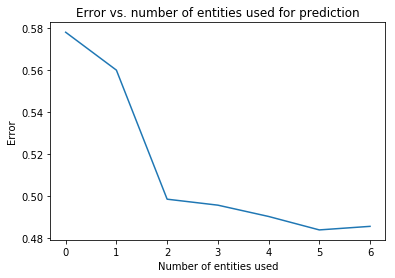

In [16]:
crowd02.plot_crowd_error(X_test_red, y_test, rmse)

In [17]:
rmse(crowd02.predict(X_test_red), y_test)

0.4681255154422219

In [10]:
supercrowd = sc.SuperCrowd()
supercrowd.append_crowd(crowd01)
supercrowd.append_crowd(crowd02)

In [15]:
rmse(supercrowd.predict(X_test_red), y_test)

0.4466822622047349

## Results
The results are good, however we remark a bias which has to be corrected using other networks in the crowd (of other type maybe).

# Mixture of experts

Finally we want to test a last method : instead of assigning the same weight to the prediction of each individual of the Crowd, we will try to assign different weights based on ressemblance between the sample to predict and the samples on which the individual performed best. 

If the data is categorizable, this method may give very good results.

In [8]:
experts01 = experts.Experts(X_train_red, y_train, "Expert01")
experts01.restore()

Recovered 40 entities from session/Expert01_8_128_relu_0.01_0.001_mse/40


In [11]:
experts01.train_new_entities(8)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20256/20282 [============================>.] - ETA: 0s - loss: 31.7339 - mean_absolute_error: 2.9845
Epoch 00001: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 7s 369us/step - loss: 31.7121 - mean_absolute_error: 2.9833 - val_loss: 14.2022 - val_mean_absolute_error: 1.8400
Epoch 2/200
20160/20282 [============================>.] - ETA: 0s - loss: 12.0730 - mean_absolute_error: 1.5785
Epoch 00002: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 200us/step - loss: 12.0493 - mean_absolute_error: 1.5747 - val_loss: 9.0266 - val_mean_absolute_error: 1.1784
Epoch 3/200
20192/20282 [============================>.] - ETA: 0s - loss: 7.1747 - mean_absolute_error: 0.8023
Epoch 00003: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 180us/step - loss

Epoch 25/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.7548 - mean_absolute_error: 0.4406
Epoch 00025: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 177us/step - loss: 0.7565 - mean_absolute_error: 0.4416 - val_loss: 0.9879 - val_mean_absolute_error: 0.5703
Epoch 26/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7464 - mean_absolute_error: 0.4255
Epoch 00026: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 177us/step - loss: 0.7462 - mean_absolute_error: 0.4254 - val_loss: 0.8024 - val_mean_absolute_error: 0.4529
Epoch 27/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.6905 - mean_absolute_error: 0.4106
Epoch 00027: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.6918 - mean_absolute_error: 0.4113 - val_loss: 

Epoch 49/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5749 - mean_absolute_error: 0.3895
Epoch 00049: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.5760 - mean_absolute_error: 0.3898 - val_loss: 0.7724 - val_mean_absolute_error: 0.5342
Epoch 50/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5684 - mean_absolute_error: 0.3946
Epoch 00050: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.5680 - mean_absolute_error: 0.3944 - val_loss: 0.6672 - val_mean_absolute_error: 0.4371
Epoch 51/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5596 - mean_absolute_error: 0.3906
Epoch 00051: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.5598 - mean_absolute_error: 0.3909 - val_loss: 

Epoch 73/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5199 - mean_absolute_error: 0.3781
Epoch 00073: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.5194 - mean_absolute_error: 0.3778 - val_loss: 0.6359 - val_mean_absolute_error: 0.4400
Epoch 74/200
19968/20282 [============================>.] - ETA: 0s - loss: 0.5196 - mean_absolute_error: 0.3793
Epoch 00074: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 177us/step - loss: 0.5206 - mean_absolute_error: 0.3800 - val_loss: 0.6310 - val_mean_absolute_error: 0.4290
Epoch 75/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5256 - mean_absolute_error: 0.3818
Epoch 00075: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 175us/step - loss: 0.5259 - mean_absolute_error: 0.3820 - val_loss: 

Epoch 97/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.4981 - mean_absolute_error: 0.3690
Epoch 00097: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 175us/step - loss: 0.4989 - mean_absolute_error: 0.3695 - val_loss: 0.6303 - val_mean_absolute_error: 0.4341
Epoch 98/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5242 - mean_absolute_error: 0.3909
Epoch 00098: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.5236 - mean_absolute_error: 0.3906 - val_loss: 0.6675 - val_mean_absolute_error: 0.4832
Epoch 99/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5199 - mean_absolute_error: 0.3878
Epoch 00099: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/32
20282/20282 [==============================] - 4s 176us/step - loss: 0.5200 - mean_absolute_error: 0.3879 - val_loss: 

Epoch 8/200
20032/20282 [============================>.] - ETA: 0s - loss: 2.2574 - mean_absolute_error: 0.5475
Epoch 00008: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 183us/step - loss: 2.2582 - mean_absolute_error: 0.5489 - val_loss: 2.2529 - val_mean_absolute_error: 0.6138
Epoch 9/200
20000/20282 [============================>.] - ETA: 0s - loss: 2.0473 - mean_absolute_error: 0.5596
Epoch 00009: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 182us/step - loss: 2.0457 - mean_absolute_error: 0.5600 - val_loss: 1.9712 - val_mean_absolute_error: 0.5625
Epoch 10/200
20128/20282 [============================>.] - ETA: 0s - loss: 1.8108 - mean_absolute_error: 0.5450
Epoch 00010: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 184us/step - loss: 1.8105 - mean_absolute_error: 0.5451 - val_loss: 1.

Epoch 32/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.6716 - mean_absolute_error: 0.4138
Epoch 00032: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 185us/step - loss: 0.6713 - mean_absolute_error: 0.4138 - val_loss: 0.7228 - val_mean_absolute_error: 0.4370
Epoch 33/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6866 - mean_absolute_error: 0.4271
Epoch 00033: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 184us/step - loss: 0.6864 - mean_absolute_error: 0.4270 - val_loss: 0.7664 - val_mean_absolute_error: 0.4784
Epoch 34/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6280 - mean_absolute_error: 0.4007
Epoch 00034: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 182us/step - loss: 0.6289 - mean_absolute_error: 0.4013 - val_loss: 

Epoch 56/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5441 - mean_absolute_error: 0.3957
Epoch 00056: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 182us/step - loss: 0.5439 - mean_absolute_error: 0.3955 - val_loss: 0.6418 - val_mean_absolute_error: 0.4458
Epoch 57/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5353 - mean_absolute_error: 0.3817
Epoch 00057: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 182us/step - loss: 0.5359 - mean_absolute_error: 0.3820 - val_loss: 0.6507 - val_mean_absolute_error: 0.4467
Epoch 58/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5547 - mean_absolute_error: 0.3979
Epoch 00058: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 183us/step - loss: 0.5558 - mean_absolute_error: 0.3983 - val_loss: 

Epoch 80/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5256 - mean_absolute_error: 0.3843
Epoch 00080: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 183us/step - loss: 0.5261 - mean_absolute_error: 0.3844 - val_loss: 0.7747 - val_mean_absolute_error: 0.5494
Epoch 81/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5188 - mean_absolute_error: 0.3851
Epoch 00081: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/33
20282/20282 [==============================] - 4s 183us/step - loss: 0.5192 - mean_absolute_error: 0.3851 - val_loss: 0.5929 - val_mean_absolute_error: 0.4281
Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20000/20282 [============================>.] - ETA: 0s - loss: 31.8436 - mean_absolute_error: 3.0165
Epoch 00001: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 7s 329us/step - loss: 

Epoch 23/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.7950 - mean_absolute_error: 0.4303
Epoch 00023: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.7952 - mean_absolute_error: 0.4306 - val_loss: 1.0248 - val_mean_absolute_error: 0.5493
Epoch 24/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.7972 - mean_absolute_error: 0.4448
Epoch 00024: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.7963 - mean_absolute_error: 0.4440 - val_loss: 0.8633 - val_mean_absolute_error: 0.4582
Epoch 25/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.7447 - mean_absolute_error: 0.4254
Epoch 00025: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.7448 - mean_absolute_error: 0.4254 - val_loss: 

Epoch 47/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5699 - mean_absolute_error: 0.4040
Epoch 00047: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 186us/step - loss: 0.5697 - mean_absolute_error: 0.4038 - val_loss: 0.6760 - val_mean_absolute_error: 0.4418
Epoch 48/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5706 - mean_absolute_error: 0.4030
Epoch 00048: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.5708 - mean_absolute_error: 0.4031 - val_loss: 0.6999 - val_mean_absolute_error: 0.4624
Epoch 49/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5787 - mean_absolute_error: 0.3989
Epoch 00049: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.5789 - mean_absolute_error: 0.3991 - val_loss: 

Epoch 71/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5278 - mean_absolute_error: 0.3850
Epoch 00071: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.5279 - mean_absolute_error: 0.3851 - val_loss: 0.6268 - val_mean_absolute_error: 0.4276
Epoch 72/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5377 - mean_absolute_error: 0.3859
Epoch 00072: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.5382 - mean_absolute_error: 0.3860 - val_loss: 0.6317 - val_mean_absolute_error: 0.4311
Epoch 73/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5381 - mean_absolute_error: 0.3901
Epoch 00073: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.5382 - mean_absolute_error: 0.3903 - val_loss: 

Epoch 95/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5065 - mean_absolute_error: 0.3763
Epoch 00095: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.5073 - mean_absolute_error: 0.3767 - val_loss: 0.6356 - val_mean_absolute_error: 0.4276
Epoch 96/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5158 - mean_absolute_error: 0.3843
Epoch 00096: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 189us/step - loss: 0.5160 - mean_absolute_error: 0.3847 - val_loss: 0.6728 - val_mean_absolute_error: 0.4520
Epoch 97/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5065 - mean_absolute_error: 0.3776
Epoch 00097: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 186us/step - loss: 0.5074 - mean_absolute_error: 0.3783 - val_loss: 

Epoch 119/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5001 - mean_absolute_error: 0.3791
Epoch 00119: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.5009 - mean_absolute_error: 0.3795 - val_loss: 0.6264 - val_mean_absolute_error: 0.4478
Epoch 120/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5065 - mean_absolute_error: 0.3764
Epoch 00120: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.5070 - mean_absolute_error: 0.3770 - val_loss: 0.6094 - val_mean_absolute_error: 0.4262
Epoch 121/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.4927 - mean_absolute_error: 0.3747
Epoch 00121: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.4924 - mean_absolute_error: 0.3746 - val_los

Epoch 143/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.4754 - mean_absolute_error: 0.3670
Epoch 00143: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 188us/step - loss: 0.4750 - mean_absolute_error: 0.3669 - val_loss: 0.6168 - val_mean_absolute_error: 0.4432
Epoch 144/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.4991 - mean_absolute_error: 0.3783
Epoch 00144: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.4989 - mean_absolute_error: 0.3782 - val_loss: 0.6358 - val_mean_absolute_error: 0.4563
Epoch 145/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.4931 - mean_absolute_error: 0.3715
Epoch 00145: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/34
20282/20282 [==============================] - 4s 187us/step - loss: 0.4942 - mean_absolute_error: 0.3721 - val_los

Epoch 11/200
20160/20282 [============================>.] - ETA: 0s - loss: 1.1514 - mean_absolute_error: 0.4961
Epoch 00011: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 1.1504 - mean_absolute_error: 0.4957 - val_loss: 1.1489 - val_mean_absolute_error: 0.5044
Epoch 12/200
20064/20282 [============================>.] - ETA: 0s - loss: 1.1759 - mean_absolute_error: 0.5404
Epoch 00012: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 1.1753 - mean_absolute_error: 0.5398 - val_loss: 1.2219 - val_mean_absolute_error: 0.5695
Epoch 13/200
20032/20282 [============================>.] - ETA: 0s - loss: 1.1048 - mean_absolute_error: 0.5127
Epoch 00013: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 1.1096 - mean_absolute_error: 0.5149 - val_loss: 

Epoch 35/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.6497 - mean_absolute_error: 0.4286
Epoch 00035: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 0.6501 - mean_absolute_error: 0.4284 - val_loss: 0.7358 - val_mean_absolute_error: 0.4524
Epoch 36/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6191 - mean_absolute_error: 0.4151
Epoch 00036: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 0.6188 - mean_absolute_error: 0.4150 - val_loss: 0.7753 - val_mean_absolute_error: 0.5090
Epoch 37/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.6094 - mean_absolute_error: 0.4112
Epoch 00037: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 193us/step - loss: 0.6092 - mean_absolute_error: 0.4112 - val_loss: 

Epoch 59/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5674 - mean_absolute_error: 0.4006
Epoch 00059: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 193us/step - loss: 0.5670 - mean_absolute_error: 0.4003 - val_loss: 0.6474 - val_mean_absolute_error: 0.4333
Epoch 60/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5581 - mean_absolute_error: 0.3980
Epoch 00060: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 194us/step - loss: 0.5584 - mean_absolute_error: 0.3983 - val_loss: 0.6808 - val_mean_absolute_error: 0.4455
Epoch 61/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5742 - mean_absolute_error: 0.4079
Epoch 00061: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 0.5736 - mean_absolute_error: 0.4074 - val_loss: 

Epoch 83/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5464 - mean_absolute_error: 0.3998
Epoch 00083: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 193us/step - loss: 0.5463 - mean_absolute_error: 0.3998 - val_loss: 0.6020 - val_mean_absolute_error: 0.4155
Epoch 84/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5263 - mean_absolute_error: 0.3818
Epoch 00084: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 192us/step - loss: 0.5266 - mean_absolute_error: 0.3820 - val_loss: 0.7039 - val_mean_absolute_error: 0.4893
Epoch 85/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5440 - mean_absolute_error: 0.3978
Epoch 00085: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/35
20282/20282 [==============================] - 4s 193us/step - loss: 0.5446 - mean_absolute_error: 0.3981 - val_loss: 

Epoch 4/200
20224/20282 [============================>.] - ETA: 0s - loss: 5.0504 - mean_absolute_error: 0.5387
Epoch 00004: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 198us/step - loss: 5.0489 - mean_absolute_error: 0.5388 - val_loss: 4.7142 - val_mean_absolute_error: 0.6008
Epoch 5/200
20224/20282 [============================>.] - ETA: 0s - loss: 4.0303 - mean_absolute_error: 0.5132
Epoch 00005: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 4.0288 - mean_absolute_error: 0.5130 - val_loss: 3.8665 - val_mean_absolute_error: 0.6317
Epoch 6/200
20064/20282 [============================>.] - ETA: 0s - loss: 3.2699 - mean_absolute_error: 0.5402
Epoch 00006: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 3.2661 - mean_absolute_error: 0.5403 - val_loss: 3.3

Epoch 28/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.6411 - mean_absolute_error: 0.4116
Epoch 00028: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 0.6409 - mean_absolute_error: 0.4115 - val_loss: 0.7921 - val_mean_absolute_error: 0.4727
Epoch 29/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.6662 - mean_absolute_error: 0.4209
Epoch 00029: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 0.6661 - mean_absolute_error: 0.4209 - val_loss: 0.7604 - val_mean_absolute_error: 0.4492
Epoch 30/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.6291 - mean_absolute_error: 0.4043
Epoch 00030: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 0.6291 - mean_absolute_error: 0.4044 - val_loss: 

Epoch 52/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5431 - mean_absolute_error: 0.3994
Epoch 00052: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 0.5435 - mean_absolute_error: 0.3996 - val_loss: 0.6493 - val_mean_absolute_error: 0.4523
Epoch 53/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5281 - mean_absolute_error: 0.3888
Epoch 00053: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 0.5279 - mean_absolute_error: 0.3886 - val_loss: 0.6440 - val_mean_absolute_error: 0.4373
Epoch 54/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5339 - mean_absolute_error: 0.3975
Epoch 00054: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 200us/step - loss: 0.5347 - mean_absolute_error: 0.3978 - val_loss: 

Epoch 76/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5149 - mean_absolute_error: 0.3864
Epoch 00076: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 199us/step - loss: 0.5142 - mean_absolute_error: 0.3860 - val_loss: 0.6038 - val_mean_absolute_error: 0.4194
Epoch 77/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5129 - mean_absolute_error: 0.3899
Epoch 00077: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 198us/step - loss: 0.5131 - mean_absolute_error: 0.3902 - val_loss: 0.7185 - val_mean_absolute_error: 0.5005
Epoch 78/200
20000/20282 [============================>.] - ETA: 0s - loss: 0.5018 - mean_absolute_error: 0.3782
Epoch 00078: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/36
20282/20282 [==============================] - 4s 198us/step - loss: 0.5018 - mean_absolute_error: 0.3780 - val_loss: 

20282/20282 [==============================] - 8s 378us/step - loss: 30.2297 - mean_absolute_error: 2.9446 - val_loss: 14.1131 - val_mean_absolute_error: 1.7843
Epoch 2/200
20000/20282 [============================>.] - ETA: 0s - loss: 12.0380 - mean_absolute_error: 1.5411
Epoch 00002: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 203us/step - loss: 11.9908 - mean_absolute_error: 1.5343 - val_loss: 9.3488 - val_mean_absolute_error: 1.1989
Epoch 3/200
20128/20282 [============================>.] - ETA: 0s - loss: 7.2912 - mean_absolute_error: 0.8002
Epoch 00003: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 203us/step - loss: 7.2828 - mean_absolute_error: 0.7997 - val_loss: 6.4018 - val_mean_absolute_error: 0.7132
Epoch 4/200
20096/20282 [============================>.] - ETA: 0s - loss: 5.3736 - mean_absolute_error: 0.5562
Epoch 00004: saving model to sess

Epoch 49/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5514 - mean_absolute_error: 0.4048
Epoch 00049: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 203us/step - loss: 0.5516 - mean_absolute_error: 0.4050 - val_loss: 0.6316 - val_mean_absolute_error: 0.4395
Epoch 50/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5283 - mean_absolute_error: 0.3879
Epoch 00050: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 205us/step - loss: 0.5281 - mean_absolute_error: 0.3880 - val_loss: 0.8374 - val_mean_absolute_error: 0.5639
Epoch 51/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5248 - mean_absolute_error: 0.3832
Epoch 00051: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 205us/step - loss: 0.5257 - mean_absolute_error: 0.3837 - val_loss: 

Epoch 73/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5085 - mean_absolute_error: 0.3821
Epoch 00073: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 206us/step - loss: 0.5083 - mean_absolute_error: 0.3820 - val_loss: 0.5999 - val_mean_absolute_error: 0.4253
Epoch 74/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.5057 - mean_absolute_error: 0.3768
Epoch 00074: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 205us/step - loss: 0.5059 - mean_absolute_error: 0.3770 - val_loss: 0.6993 - val_mean_absolute_error: 0.4862
Epoch 75/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5048 - mean_absolute_error: 0.3861
Epoch 00075: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 205us/step - loss: 0.5046 - mean_absolute_error: 0.3860 - val_loss: 

Epoch 97/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.4849 - mean_absolute_error: 0.3729
Epoch 00097: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 204us/step - loss: 0.4846 - mean_absolute_error: 0.3729 - val_loss: 0.5757 - val_mean_absolute_error: 0.4189
Epoch 98/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.4836 - mean_absolute_error: 0.3714
Epoch 00098: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 204us/step - loss: 0.4838 - mean_absolute_error: 0.3718 - val_loss: 0.6058 - val_mean_absolute_error: 0.4350
Epoch 99/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5017 - mean_absolute_error: 0.3872
Epoch 00099: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/37
20282/20282 [==============================] - 4s 205us/step - loss: 0.5015 - mean_absolute_error: 0.3871 - val_loss: 

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20096/20282 [============================>.] - ETA: 0s - loss: 31.4193 - mean_absolute_error: 2.9879
Epoch 00001: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 8s 390us/step - loss: 31.2850 - mean_absolute_error: 2.9793 - val_loss: 14.8877 - val_mean_absolute_error: 1.8725
Epoch 2/200
20128/20282 [============================>.] - ETA: 0s - loss: 12.5351 - mean_absolute_error: 1.6638
Epoch 00002: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 209us/step - loss: 12.5062 - mean_absolute_error: 1.6594 - val_loss: 9.7004 - val_mean_absolute_error: 1.3044
Epoch 3/200
20064/20282 [============================>.] - ETA: 0s - loss: 7.4307 - mean_absolute_error: 0.8536
Epoch 00003: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 207us/step - loss

Epoch 25/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.7315 - mean_absolute_error: 0.4235
Epoch 00025: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 209us/step - loss: 0.7316 - mean_absolute_error: 0.4236 - val_loss: 1.1541 - val_mean_absolute_error: 0.6706
Epoch 26/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.7556 - mean_absolute_error: 0.4350
Epoch 00026: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.7556 - mean_absolute_error: 0.4351 - val_loss: 0.8270 - val_mean_absolute_error: 0.4658
Epoch 27/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.7022 - mean_absolute_error: 0.4269
Epoch 00027: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.7017 - mean_absolute_error: 0.4263 - val_loss: 

Epoch 49/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5301 - mean_absolute_error: 0.3939
Epoch 00049: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.5305 - mean_absolute_error: 0.3940 - val_loss: 0.6374 - val_mean_absolute_error: 0.4343
Epoch 50/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5564 - mean_absolute_error: 0.4023
Epoch 00050: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 210us/step - loss: 0.5559 - mean_absolute_error: 0.4020 - val_loss: 0.7003 - val_mean_absolute_error: 0.4948
Epoch 51/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5192 - mean_absolute_error: 0.3822
Epoch 00051: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.5194 - mean_absolute_error: 0.3822 - val_loss: 

Epoch 73/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5198 - mean_absolute_error: 0.3822
Epoch 00073: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.5198 - mean_absolute_error: 0.3822 - val_loss: 0.6046 - val_mean_absolute_error: 0.4295
Epoch 74/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5051 - mean_absolute_error: 0.3795
Epoch 00074: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.5059 - mean_absolute_error: 0.3800 - val_loss: 0.5810 - val_mean_absolute_error: 0.4210
Epoch 75/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.5029 - mean_absolute_error: 0.3768
Epoch 00075: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.5036 - mean_absolute_error: 0.3773 - val_loss: 

Epoch 97/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5103 - mean_absolute_error: 0.3851
Epoch 00097: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 208us/step - loss: 0.5097 - mean_absolute_error: 0.3845 - val_loss: 0.5860 - val_mean_absolute_error: 0.4243
Epoch 98/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.4808 - mean_absolute_error: 0.3682
Epoch 00098: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 206us/step - loss: 0.4812 - mean_absolute_error: 0.3684 - val_loss: 0.6439 - val_mean_absolute_error: 0.4639
Epoch 99/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.4952 - mean_absolute_error: 0.3815
Epoch 00099: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 207us/step - loss: 0.4951 - mean_absolute_error: 0.3815 - val_loss: 

Epoch 121/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5023 - mean_absolute_error: 0.3851
Epoch 00121: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 210us/step - loss: 0.5022 - mean_absolute_error: 0.3850 - val_loss: 0.6358 - val_mean_absolute_error: 0.4377
Epoch 122/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.4775 - mean_absolute_error: 0.3637
Epoch 00122: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 213us/step - loss: 0.4774 - mean_absolute_error: 0.3637 - val_loss: 0.5893 - val_mean_absolute_error: 0.4404
Epoch 123/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.4732 - mean_absolute_error: 0.3652
Epoch 00123: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/38
20282/20282 [==============================] - 4s 218us/step - loss: 0.4730 - mean_absolute_error: 0.3652 - val_los

Epoch 17/200
20096/20282 [============================>.] - ETA: 0s - loss: 1.0600 - mean_absolute_error: 0.4925
Epoch 00017: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 213us/step - loss: 1.0592 - mean_absolute_error: 0.4922 - val_loss: 1.1076 - val_mean_absolute_error: 0.5106
Epoch 18/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.9977 - mean_absolute_error: 0.4732
Epoch 00018: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 213us/step - loss: 0.9968 - mean_absolute_error: 0.4724 - val_loss: 1.1475 - val_mean_absolute_error: 0.5143
Epoch 19/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.9499 - mean_absolute_error: 0.4680
Epoch 00019: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 213us/step - loss: 0.9501 - mean_absolute_error: 0.4682 - val_loss: 

Epoch 41/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5909 - mean_absolute_error: 0.4084
Epoch 00041: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 213us/step - loss: 0.5914 - mean_absolute_error: 0.4088 - val_loss: 0.7724 - val_mean_absolute_error: 0.5023
Epoch 42/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5668 - mean_absolute_error: 0.3898
Epoch 00042: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 213us/step - loss: 0.5668 - mean_absolute_error: 0.3900 - val_loss: 0.7103 - val_mean_absolute_error: 0.4720
Epoch 43/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.5736 - mean_absolute_error: 0.4008
Epoch 00043: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 214us/step - loss: 0.5740 - mean_absolute_error: 0.4010 - val_loss: 

Epoch 65/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.5323 - mean_absolute_error: 0.3832
Epoch 00065: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 212us/step - loss: 0.5327 - mean_absolute_error: 0.3835 - val_loss: 0.6559 - val_mean_absolute_error: 0.4565
Epoch 66/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5337 - mean_absolute_error: 0.3867
Epoch 00066: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 213us/step - loss: 0.5337 - mean_absolute_error: 0.3867 - val_loss: 0.6732 - val_mean_absolute_error: 0.4386
Epoch 67/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.5271 - mean_absolute_error: 0.3816
Epoch 00067: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 212us/step - loss: 0.5267 - mean_absolute_error: 0.3813 - val_loss: 

Epoch 89/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.5201 - mean_absolute_error: 0.3778
Epoch 00089: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 5s 226us/step - loss: 0.5197 - mean_absolute_error: 0.3775 - val_loss: 0.5991 - val_mean_absolute_error: 0.4144
Epoch 90/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.5109 - mean_absolute_error: 0.3838
Epoch 00090: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 217us/step - loss: 0.5115 - mean_absolute_error: 0.3841 - val_loss: 0.6102 - val_mean_absolute_error: 0.4365
Epoch 91/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.5061 - mean_absolute_error: 0.3804
Epoch 00091: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 219us/step - loss: 0.5070 - mean_absolute_error: 0.3811 - val_loss: 

Epoch 113/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.4876 - mean_absolute_error: 0.3716
Epoch 00113: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 216us/step - loss: 0.4885 - mean_absolute_error: 0.3722 - val_loss: 0.6867 - val_mean_absolute_error: 0.4964
Epoch 114/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.4884 - mean_absolute_error: 0.3728
Epoch 00114: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 217us/step - loss: 0.4883 - mean_absolute_error: 0.3727 - val_loss: 0.5957 - val_mean_absolute_error: 0.4175
Epoch 115/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.4902 - mean_absolute_error: 0.3708
Epoch 00115: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 4s 216us/step - loss: 0.4916 - mean_absolute_error: 0.3716 - val_los

Epoch 137/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.4667 - mean_absolute_error: 0.3662
Epoch 00137: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 5s 227us/step - loss: 0.4663 - mean_absolute_error: 0.3659 - val_loss: 0.6198 - val_mean_absolute_error: 0.4321
Epoch 138/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.4950 - mean_absolute_error: 0.3799
Epoch 00138: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 5s 223us/step - loss: 0.4951 - mean_absolute_error: 0.3800 - val_loss: 0.6005 - val_mean_absolute_error: 0.4327
Epoch 139/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.4999 - mean_absolute_error: 0.3790
Epoch 00139: saving model to session/Expert01_8_128_relu_0.01_0.001_mse/39
20282/20282 [==============================] - 5s 234us/step - loss: 0.4999 - mean_absolute_error: 0.3790 - val_los

In [9]:
experts01.predict_kmeans(X_test_red, rmse, 8)

##############
# Clustering #
##############
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 345561549.9796525
start iteration
done sorting
end inner loop
Iteration 1, inertia 340154149.0932679
start iteration
done sorting
end inner loop
Iteration 2, inertia 337111488.1562936
start iteration
done sorting
end inner loop
Iteration 3, inertia 336713541.95551527
start iteration
done sorting
end inner loop
Iteration 4, inertia 336611340.4379335
start iteration
done sorting
end inner loop
Iteration 5, inertia 336557339.5564094
start iteration
done sorting
end inner loop
Iteration 6, inertia 336519100.48057765
start iteration
done sorting
end inner loop
Iteration 7, inertia 336490849.1220859
start iteration
done sorting
end inner loop
Iteration 8, inertia 336467078.6276319
start iteration
done sorting
end inner loop
Iteration 9, inertia 336433944.2335675
start iteration
done sorting
end inner loop
Iteration 10, inertia 336376362.262358
start iteration


Iteration 17, inertia 330389291.41920125
start iteration
done sorting
end inner loop
Iteration 18, inertia 330388968.2101261
start iteration
done sorting
end inner loop
Iteration 19, inertia 330388690.61977994
start iteration
done sorting
end inner loop
Iteration 20, inertia 330388483.8516841
start iteration
done sorting
end inner loop
Iteration 21, inertia 330388291.01398575
start iteration
done sorting
end inner loop
Iteration 22, inertia 330388171.81806123
start iteration
done sorting
end inner loop
Iteration 23, inertia 330388069.0533968
start iteration
done sorting
end inner loop
Iteration 24, inertia 330387877.70004094
start iteration
done sorting
end inner loop
Iteration 25, inertia 330387380.1466421
start iteration
done sorting
end inner loop
Iteration 26, inertia 330386836.18664944
start iteration
done sorting
end inner loop
Iteration 27, inertia 330386411.1389745
start iteration
done sorting
end inner loop
Iteration 28, inertia 330386050.5459479
start iteration
done sorting
e

Iteration 3, inertia 335154500.700117
start iteration
done sorting
end inner loop
Iteration 4, inertia 334885121.9628132
start iteration
done sorting
end inner loop
Iteration 5, inertia 334789100.367616
start iteration
done sorting
end inner loop
Iteration 6, inertia 334724536.97452086
start iteration
done sorting
end inner loop
Iteration 7, inertia 334661504.5325941
start iteration
done sorting
end inner loop
Iteration 8, inertia 334604756.8719873
start iteration
done sorting
end inner loop
Iteration 9, inertia 334553448.6192124
start iteration
done sorting
end inner loop
Iteration 10, inertia 334517721.879492
start iteration
done sorting
end inner loop
Iteration 11, inertia 334496917.30222386
start iteration
done sorting
end inner loop
Iteration 12, inertia 334483798.5600231
start iteration
done sorting
end inner loop
Iteration 13, inertia 334476697.4123786
start iteration
done sorting
end inner loop
Iteration 14, inertia 334472664.2944148
start iteration
done sorting
end inner loop


Iteration 68, inertia 329240534.0261807
start iteration
done sorting
end inner loop
Iteration 69, inertia 329240534.0261807
center shift 0.000000e+00 within tolerance 5.200809e-04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 343611491.2846297
start iteration
done sorting
end inner loop
Iteration 1, inertia 336195829.84397286
start iteration
done sorting
end inner loop
Iteration 2, inertia 331420911.4944014
start iteration
done sorting
end inner loop
Iteration 3, inertia 329308663.9090084
start iteration
done sorting
end inner loop
Iteration 4, inertia 328064551.7639317
start iteration
done sorting
end inner loop
Iteration 5, inertia 327330744.04127
start iteration
done sorting
end inner loop
Iteration 6, inertia 327265599.51059407
start iteration
done sorting
end inner loop
Iteration 7, inertia 327251627.6896297
start iteration
done sorting
end inner loop
Iteration 8, inertia 327241613.2956979
start iteration
done sorting
end inner loop
Itera

Iteration 10, inertia 332451266.1880289
start iteration
done sorting
end inner loop
Iteration 11, inertia 332397581.3652236
start iteration
done sorting
end inner loop
Iteration 12, inertia 332315399.03390145
start iteration
done sorting
end inner loop
Iteration 13, inertia 332146318.9651932
start iteration
done sorting
end inner loop
Iteration 14, inertia 331897164.299343
start iteration
done sorting
end inner loop
Iteration 15, inertia 331704078.9408754
start iteration
done sorting
end inner loop
Iteration 16, inertia 331577725.7282849
start iteration
done sorting
end inner loop
Iteration 17, inertia 331373025.4265763
start iteration
done sorting
end inner loop
Iteration 18, inertia 331139781.6217852
start iteration
done sorting
end inner loop
Iteration 19, inertia 330718354.65242857
start iteration
done sorting
end inner loop
Iteration 20, inertia 329807715.1272789
start iteration
done sorting
end inner loop
Iteration 21, inertia 329580879.33371466
start iteration
done sorting
end i

Iteration 14, inertia 333762836.74135256
start iteration
done sorting
end inner loop
Iteration 15, inertia 333761858.6738627
start iteration
done sorting
end inner loop
Iteration 16, inertia 333761259.2718671
start iteration
done sorting
end inner loop
Iteration 17, inertia 333760967.2197978
start iteration
done sorting
end inner loop
Iteration 18, inertia 333760658.128698
start iteration
done sorting
end inner loop
Iteration 19, inertia 333760437.36753154
start iteration
done sorting
end inner loop
Iteration 20, inertia 333760264.82648593
start iteration
done sorting
end inner loop
Iteration 21, inertia 333760029.77894247
start iteration
done sorting
end inner loop
Iteration 22, inertia 333759893.9143616
start iteration
done sorting
end inner loop
Iteration 23, inertia 333759798.1745502
start iteration
done sorting
end inner loop
Iteration 24, inertia 333759703.06963396
start iteration
done sorting
end inner loop
Iteration 25, inertia 333759630.0360836
start iteration
done sorting
end

Cluster 4 (884 entities) : brains : [18.  1. 11. 37. 21.], losses : [0.47024992 0.47523214 0.4960051  0.49355714 0.49855832]
Cluster 5 (8083 entities) : brains : [15. 21. 18. 33. 35.], losses : [0.41018836 0.40731534 0.41242831 0.41224697 0.39740584]
Cluster 6 (923 entities) : brains : [30. 31. 25. 39. 33.], losses : [0.73683449 0.72521815 0.73566453 0.72802726 0.74755046]
Cluster 7 (6554 entities) : brains : [32. 22. 15. 18. 33.], losses : [0.40564093 0.40279863 0.39848548 0.40058314 0.39218838]


[30.505478,
 32.531975,
 30.198786,
 28.024326,
 28.656992,
 29.839468,
 29.24318,
 29.30816,
 29.98764,
 30.329685,
 29.143711,
 30.839127,
 24.08931,
 27.95637,
 28.30622,
 26.213642,
 28.70043,
 23.177698,
 22.95524,
 22.911396,
 26.853573,
 26.471233,
 22.372044,
 23.814215,
 22.578129,
 28.917553,
 25.785267,
 28.32825,
 28.192154,
 29.059229,
 26.79043,
 30.05138,
 29.267048,
 28.502508,
 28.841213,
 26.566925,
 25.566435,
 23.985035,
 23.738941,
 23.35844,
 22.354538,
 22.790333,
 22.863356,
 23.598003,
 22.5274,
 22.647236,
 17.393303,
 29.130499,
 28.41219,
 30.368916,
 29.417349,
 29.028141,
 27.346188,
 29.193436,
 27.697678,
 28.054798,
 27.043997,
 27.436749,
 25.795893,
 29.313543,
 29.115911,
 31.039011,
 29.935665,
 27.3888,
 27.281576,
 27.895176,
 29.492893,
 29.681927,
 25.849575,
 21.348118,
 29.507797,
 22.207933,
 30.565466,
 29.434017,
 24.221508,
 23.367329,
 18.875357,
 20.3843,
 24.514563,
 24.465923,
 22.666126,
 28.496927,
 29.089916,
 28.635477,
 30.366892,

In [10]:
rmse(experts01.predict_kmeans(X_test_red, rmse, 4), y_test), rmse(experts01.predict_kmeans(X_train_red, rmse, 4), y_train)

(0.4561795724701411, 0.32883888792602867)

## Conversion from vectors to images
This part is dedicated to test if vectors can be easily classified. This is important to know since the gateway we are running tries to classify the vectors in categories (represented by the brain that makes the best final prediction).

Then we transfrom our vectors into images, and we display several images for each brains, hoping that the images of one brain will be distinguishables from another. This would confort us in the idea that vectors are easily classifiable.

In [22]:
def to_image(sample, size):
    img = np.zeros((54, 54))
    max_ = max(sample)
    min_ = min(sample)
    for i, s in enumerate(sample):
        if i >= 54**2:
            break
        img[i // 54][i % 54] = (s - min_)/(max_ - min_)*255
    im = Image.fromarray(img)
    im = im.resize((size,size), Image.ANTIALIAS)
    im.show()

In [46]:
gateway_matrix = experts01.get_gateway_matrix()
BRAIN_NB = 3
brain_samples = []
for i, g in enumerate(gateway_matrix):
    if g == BRAIN_NB:
        brain_samples.append(X_train_red[i])
        
print(len(brain_samples))

599


In [45]:
for b in brain_samples[:3]:
    to_image(b, 256)

## Conclusion on image conversion

After comparing the images of several brain, we concluded that they are not very different from each others, we can hardly detect patterns that appear in one set of images and not in another. This result suggests that our vectors are not classifiable. 

Was is certain is that they are not diffentiable enough for basic classification algorithms (e.g the ones used in image classification) to classify them efficiently, which goes in the same sens than our experiences so far.

#  Optimization

We find the best set of parameters for our model to give the best predictions. Once the best single neural network has been found, we create a Crowd composed of instances of this network to reduce the error even further.

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [6]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


In [30]:
def train_and_pred(nb_layers, nb_neurons, regularizer_fac, optimizer_fac):
    # Prepare model 
    model = tf.keras.Sequential()
    for i in range(nb_layers):
        model.add(layers.Dense(nb_neurons, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(regularizer_fac)))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(optimizer_fac),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)
    
    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

### Results of cross validation over regularization factor

For the sake of sanity, we only display the results we obtained to avoid recomputing them. The following graph shows evolution of the RMSE for a single neural network versus the L2 regularization factor.

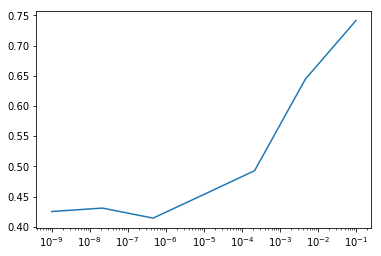

In [24]:
errors = [0.7416394267991249, 0.6443409956831526, 0.4930030937745785, \
         0.453638706377575, 0.41453323956187177, 0.4311010863788413, 0.4254569121978898]

x = np.logspace(-1, -9, 7)

plt.semilogx(x, errors)

In [10]:
crowd_opt1 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_1", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6)
crowd_opt1.restore()

Recovered 16 entities from session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/16


In [23]:
crowd_opt1.train_new_entities(4)

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20128/20282 [============================>.] - ETA: 0s - loss: 20.5110 - mean_absolute_error: 2.8363
Epoch 00001: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/12
20282/20282 [==============================] - 10s 487us/step - loss: 20.4025 - mean_absolute_error: 2.8286 - val_loss: 6.7400 - val_mean_absolute_error: 1.9607
Epoch 2/200
20160/20282 [============================>.] - ETA: 0s - loss: 4.4062 - mean_absolute_error: 1.5043
Epoch 00002: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/12
20282/20282 [==============================] - 8s 419us/step - loss: 4.3930 - mean_absolute_error: 1.5018 - val_loss: 3.2508 - val_mean_absolute_error: 1.4215
Epoch 3/200
20128/20282 [============================>.] - ETA: 0s - loss: 1.1781 - mean_absolute_error: 0.7634
Epoch 00003: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/12
20282/20282 [==============================] - 7s 326us/s

Epoch 48/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.1710
Epoch 00048: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/12
20282/20282 [==============================] - 4s 214us/step - loss: 0.0576 - mean_absolute_error: 0.1710 - val_loss: 0.2574 - val_mean_absolute_error: 0.3456
Epoch 49/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.1730
Epoch 00049: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/12
20282/20282 [==============================] - 5s 230us/step - loss: 0.0588 - mean_absolute_error: 0.1727 - val_loss: 0.2388 - val_mean_absolute_error: 0.3153
Epoch 50/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.0528 - mean_absolute_error: 0.1566
Epoch 00050: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/12
20282/20282 [==============================] - 4s 220us/step - loss: 0.0528 - mean_absolute_error: 0.1566 

Epoch 29/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.1006 - mean_absolute_error: 0.2294
Epoch 00029: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 4s 217us/step - loss: 0.1006 - mean_absolute_error: 0.2294 - val_loss: 0.2523 - val_mean_absolute_error: 0.3387
Epoch 30/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.0993 - mean_absolute_error: 0.2304
Epoch 00030: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 5s 226us/step - loss: 0.0994 - mean_absolute_error: 0.2307 - val_loss: 0.3265 - val_mean_absolute_error: 0.4226
Epoch 31/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.0928 - mean_absolute_error: 0.2223
Epoch 00031: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 4s 219us/step - loss: 0.0928 - mean_absolute_error: 0.2225 

Epoch 53/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.1553
Epoch 00053: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 5s 257us/step - loss: 0.0478 - mean_absolute_error: 0.1553 - val_loss: 0.2197 - val_mean_absolute_error: 0.3039
Epoch 54/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.0504 - mean_absolute_error: 0.1568
Epoch 00054: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 5s 246us/step - loss: 0.0504 - mean_absolute_error: 0.1568 - val_loss: 0.2186 - val_mean_absolute_error: 0.3013
Epoch 55/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.1507
Epoch 00055: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 5s 245us/step - loss: 0.0472 - mean_absolute_error: 0.1504 

Epoch 77/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.1319
Epoch 00077: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 5s 223us/step - loss: 0.0393 - mean_absolute_error: 0.1318 - val_loss: 0.2250 - val_mean_absolute_error: 0.3020
Epoch 78/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.1283
Epoch 00078: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 4s 219us/step - loss: 0.0375 - mean_absolute_error: 0.1283 - val_loss: 0.2131 - val_mean_absolute_error: 0.2909
Epoch 79/200
20064/20282 [============================>.] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.1264
Epoch 00079: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/13
20282/20282 [==============================] - 4s 220us/step - loss: 0.0370 - mean_absolute_error: 0.1266 

Epoch 40/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.1909
Epoch 00040: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 5s 227us/step - loss: 0.0855 - mean_absolute_error: 0.1908 - val_loss: 0.2110 - val_mean_absolute_error: 0.3066
Epoch 41/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.0651 - mean_absolute_error: 0.1825
Epoch 00041: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 5s 224us/step - loss: 0.0651 - mean_absolute_error: 0.1824 - val_loss: 0.2233 - val_mean_absolute_error: 0.3128
Epoch 42/200
20096/20282 [============================>.] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1844
Epoch 00042: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 4s 221us/step - loss: 0.0681 - mean_absolute_error: 0.1841 

Epoch 64/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.1301
Epoch 00064: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 5s 224us/step - loss: 0.0387 - mean_absolute_error: 0.1304 - val_loss: 0.2198 - val_mean_absolute_error: 0.3111
Epoch 65/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.1294
Epoch 00065: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 5s 224us/step - loss: 0.0387 - mean_absolute_error: 0.1297 - val_loss: 0.2295 - val_mean_absolute_error: 0.3289
Epoch 66/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.1351
Epoch 00066: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 5s 223us/step - loss: 0.0411 - mean_absolute_error: 0.1351 

Epoch 88/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.1079
Epoch 00088: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 4s 220us/step - loss: 0.0295 - mean_absolute_error: 0.1079 - val_loss: 0.1879 - val_mean_absolute_error: 0.2739
Epoch 89/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.1100
Epoch 00089: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 4s 221us/step - loss: 0.0303 - mean_absolute_error: 0.1099 - val_loss: 0.1929 - val_mean_absolute_error: 0.2798
Epoch 90/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.1173
Epoch 00090: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/14
20282/20282 [==============================] - 4s 221us/step - loss: 0.0329 - mean_absolute_error: 0.1174 

20224/20282 [============================>.] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.3437
Epoch 00017: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 230us/step - loss: 0.2131 - mean_absolute_error: 0.3437 - val_loss: 0.3209 - val_mean_absolute_error: 0.4046
Epoch 18/200
20192/20282 [============================>.] - ETA: 0s - loss: 0.1883 - mean_absolute_error: 0.3266
Epoch 00018: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 226us/step - loss: 0.1884 - mean_absolute_error: 0.3266 - val_loss: 0.3237 - val_mean_absolute_error: 0.4079
Epoch 19/200
20256/20282 [============================>.] - ETA: 0s - loss: 0.1748 - mean_absolute_error: 0.3120
Epoch 00019: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 228us/step - loss: 0.1750 - mean_absolute_error: 0.3120 - val_loss: 0

Epoch 41/200
20224/20282 [============================>.] - ETA: 0s - loss: 0.1051 - mean_absolute_error: 0.1805
Epoch 00041: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 4s 222us/step - loss: 0.1108 - mean_absolute_error: 0.1840 - val_loss: 0.4620 - val_mean_absolute_error: 0.5484
Epoch 42/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.2025
Epoch 00042: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 223us/step - loss: 0.0865 - mean_absolute_error: 0.2023 - val_loss: 0.2450 - val_mean_absolute_error: 0.3396
Epoch 43/200
20032/20282 [============================>.] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.1384
Epoch 00043: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 226us/step - loss: 0.0401 - mean_absolute_error: 0.1386 

Epoch 65/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.1355
Epoch 00065: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 228us/step - loss: 0.0401 - mean_absolute_error: 0.1356 - val_loss: 0.2078 - val_mean_absolute_error: 0.2997
Epoch 66/200
20128/20282 [============================>.] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.1494
Epoch 00066: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 229us/step - loss: 0.0458 - mean_absolute_error: 0.1494 - val_loss: 0.2462 - val_mean_absolute_error: 0.3461
Epoch 67/200
20160/20282 [============================>.] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.1354
Epoch 00067: saving model to session/Crowd_opt_1_8_156_relu_1e-06_0.001_mse/15
20282/20282 [==============================] - 5s 242us/step - loss: 0.0403 - mean_absolute_error: 0.1358 

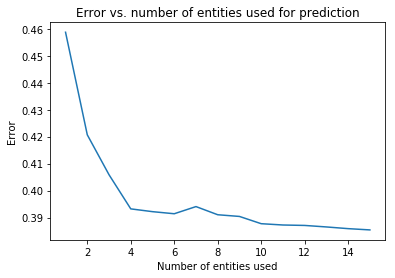

In [9]:
crowd_opt1.plot_crowd_error(X_test_red, y_test, rmse)

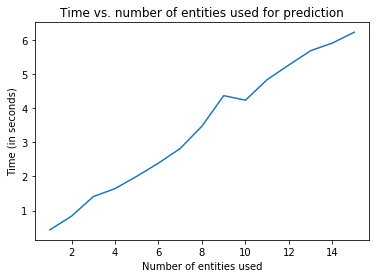

In [11]:
crowd_opt1.plot_crowd_pred_time(X_test_red)

In [14]:
start = timeit.default_timer()
pred = crowd_opt1.predict(X_test_red)
stop = timeit.default_timer()
error_rmse = rmse(pred, y_test)
print('Prediction time for {} samples : {} seconds\nRMSE : {} '.format(len(X_test_red), stop - start, error_rmse))

Prediction time for 7513 samples : 6.489019888000257 seconds
RMSE : 0.38542022789349456 


In [7]:
crowd_opt2 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
crowd_opt2.restore()

Recovered 16 entities from session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/16


In [17]:
rmse(crowd_opt2.predict_stacked(X_test_red), y_test)

(3004,) (22536, 16)
Epoch 1/200
22536/22536 [==============================] - 7s 290us/step - loss: 6.0457 - mean_absolute_error: 1.0891
Epoch 2/200
22536/22536 [==============================] - 5s 214us/step - loss: 0.6616 - mean_absolute_error: 0.5377
Epoch 3/200
22536/22536 [==============================] - 5s 214us/step - loss: 0.5609 - mean_absolute_error: 0.4994
Epoch 4/200
22536/22536 [==============================] - 5s 214us/step - loss: 0.4016 - mean_absolute_error: 0.4431
Epoch 5/200
22536/22536 [==============================] - 5s 214us/step - loss: 0.2825 - mean_absolute_error: 0.3598
Epoch 6/200
22536/22536 [==============================] - 5s 215us/step - loss: 0.3134 - mean_absolute_error: 0.4042
Epoch 7/200
22536/22536 [==============================] - 5s 218us/step - loss: 0.3581 - mean_absolute_error: 0.4150
Epoch 8/200
22536/22536 [==============================] - 5s 217us/step - loss: 0.2093 - mean_absolute_error: 0.3137
Epoch 9/200
22536/22536 [===========

0.3866655525069518

In [26]:
crowd_opt2.train_new_entities(8)

Epoch 1/200
22528/22536 [============================>.] - ETA: 0s - loss: 41.6880 - mean_absolute_error: 3.7409
Epoch 00001: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 13s 580us/step - loss: 41.6742 - mean_absolute_error: 3.7401
Epoch 2/200
22400/22536 [============================>.] - ETA: 0s - loss: 2.6644 - mean_absolute_error: 1.1367
Epoch 00002: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 6s 257us/step - loss: 2.6524 - mean_absolute_error: 1.1337
Epoch 3/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.5606 - mean_absolute_error: 0.5513
Epoch 00003: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 6s 263us/step - loss: 0.5605 - mean_absolute_error: 0.5512
Epoch 4/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.4284 - mean_absolute_error: 0.49

22536/22536 [==============================] - 5s 244us/step - loss: 0.0965 - mean_absolute_error: 0.2121
Epoch 29/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0903 - mean_absolute_error: 0.2098
Epoch 00029: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 6s 249us/step - loss: 0.0904 - mean_absolute_error: 0.2101
Epoch 30/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.1186 - mean_absolute_error: 0.2356
Epoch 00030: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 6s 255us/step - loss: 0.1184 - mean_absolute_error: 0.2356
Epoch 31/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0836 - mean_absolute_error: 0.2056
Epoch 00031: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 6s 250us/step - loss: 0.0837 - mean_absolute_error: 0.2057
Epo

22536/22536 [==============================] - 5s 242us/step - loss: 0.0370 - mean_absolute_error: 0.1220
Epoch 84/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.1202
Epoch 00084: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 242us/step - loss: 0.0352 - mean_absolute_error: 0.1206
Epoch 85/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.1217
Epoch 00085: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 243us/step - loss: 0.0364 - mean_absolute_error: 0.1217
Epoch 86/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.1140
Epoch 00086: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 240us/step - loss: 0.0336 - mean_absolute_error: 0.1141
Epo

Epoch 139/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0961
Epoch 00139: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 238us/step - loss: 0.0263 - mean_absolute_error: 0.0962
Epoch 140/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.1057
Epoch 00140: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 236us/step - loss: 0.0297 - mean_absolute_error: 0.1056
Epoch 141/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.1090
Epoch 00141: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 237us/step - loss: 0.0308 - mean_absolute_error: 0.1090
Epoch 142/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0283 - mean_absolute_error:

Epoch 167/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.0933
Epoch 00167: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 237us/step - loss: 0.0248 - mean_absolute_error: 0.0932
Epoch 168/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0887
Epoch 00168: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 238us/step - loss: 0.0232 - mean_absolute_error: 0.0887
Epoch 169/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.1017
Epoch 00169: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 236us/step - loss: 0.0280 - mean_absolute_error: 0.1016
Epoch 170/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0270 - mean_absolute_error:

Epoch 195/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.0924
Epoch 00195: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 237us/step - loss: 0.0242 - mean_absolute_error: 0.0924
Epoch 196/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0929
Epoch 00196: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 237us/step - loss: 0.0244 - mean_absolute_error: 0.0929
Epoch 197/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0234 - mean_absolute_error: 0.0906
Epoch 00197: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/8
22536/22536 [==============================] - 5s 236us/step - loss: 0.0234 - mean_absolute_error: 0.0905
Epoch 198/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0243 - mean_absolute_error:

Epoch 23/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.1904 - mean_absolute_error: 0.2641
Epoch 00023: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 240us/step - loss: 0.1902 - mean_absolute_error: 0.2645
Epoch 24/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.1243 - mean_absolute_error: 0.2588
Epoch 00024: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 240us/step - loss: 0.1243 - mean_absolute_error: 0.2586
Epoch 25/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0872 - mean_absolute_error: 0.2147
Epoch 00025: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 243us/step - loss: 0.0872 - mean_absolute_error: 0.2147
Epoch 26/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0937 - mean_absolute_error: 0.2

Epoch 51/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.1486
Epoch 00051: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 242us/step - loss: 0.0473 - mean_absolute_error: 0.1486
Epoch 52/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0467 - mean_absolute_error: 0.1486
Epoch 00052: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 240us/step - loss: 0.0467 - mean_absolute_error: 0.1486
Epoch 53/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.1391
Epoch 00053: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 241us/step - loss: 0.0421 - mean_absolute_error: 0.1391
Epoch 54/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.1

22536/22536 [==============================] - 5s 240us/step - loss: 0.0312 - mean_absolute_error: 0.1118
Epoch 79/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.1154
Epoch 00079: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 5s 240us/step - loss: 0.0339 - mean_absolute_error: 0.1158
Epoch 80/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.1168
Epoch 00080: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 10s 458us/step - loss: 0.0337 - mean_absolute_error: 0.1168
Epoch 81/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.1187
Epoch 00081: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 38s 2ms/step - loss: 0.0339 - mean_absolute_error: 0.1187
Epo

Epoch 134/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0252 - mean_absolute_error: 0.0950
Epoch 00134: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 258us/step - loss: 0.0251 - mean_absolute_error: 0.0949
Epoch 135/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0926
Epoch 00135: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 256us/step - loss: 0.0247 - mean_absolute_error: 0.0931
Epoch 136/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.1048
Epoch 00136: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 277us/step - loss: 0.0292 - mean_absolute_error: 0.1047
Epoch 137/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0256 - mean_absolute_error:

Epoch 162/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0227 - mean_absolute_error: 0.0872
Epoch 00162: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 275us/step - loss: 0.0227 - mean_absolute_error: 0.0872
Epoch 163/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0986
Epoch 00163: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 286us/step - loss: 0.0263 - mean_absolute_error: 0.0984
Epoch 164/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0912
Epoch 00164: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 266us/step - loss: 0.0244 - mean_absolute_error: 0.0912
Epoch 165/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0245 - mean_absolute_error:

Epoch 190/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.0889
Epoch 00190: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 245us/step - loss: 0.0229 - mean_absolute_error: 0.0889
Epoch 191/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0950
Epoch 00191: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 254us/step - loss: 0.0246 - mean_absolute_error: 0.0950
Epoch 192/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0228 - mean_absolute_error: 0.0871
Epoch 00192: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/9
22536/22536 [==============================] - 6s 261us/step - loss: 0.0228 - mean_absolute_error: 0.0871
Epoch 193/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0222 - mean_absolute_error:

Epoch 18/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.1785 - mean_absolute_error: 0.2997
Epoch 00018: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 274us/step - loss: 0.1785 - mean_absolute_error: 0.3000
Epoch 19/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.2276 - mean_absolute_error: 0.3377
Epoch 00019: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 270us/step - loss: 0.2274 - mean_absolute_error: 0.3376
Epoch 20/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.1840 - mean_absolute_error: 0.3084
Epoch 00020: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 7s 316us/step - loss: 0.1840 - mean_absolute_error: 0.3084
Epoch 21/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.1507 - mean_absolute_error: 

Epoch 46/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0543 - mean_absolute_error: 0.1652
Epoch 00046: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 283us/step - loss: 0.0542 - mean_absolute_error: 0.1651
Epoch 47/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0534 - mean_absolute_error: 0.1628
Epoch 00047: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 267us/step - loss: 0.0533 - mean_absolute_error: 0.1628
Epoch 48/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.1659
Epoch 00048: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 7s 312us/step - loss: 0.0553 - mean_absolute_error: 0.1658
Epoch 49/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0524 - mean_absolute_error: 

Epoch 74/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.1192
Epoch 00074: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 7s 325us/step - loss: 0.0343 - mean_absolute_error: 0.1191
Epoch 75/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.1203
Epoch 00075: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 7s 310us/step - loss: 0.0350 - mean_absolute_error: 0.1203
Epoch 76/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.1188
Epoch 00076: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 7s 290us/step - loss: 0.0344 - mean_absolute_error: 0.1190
Epoch 77/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 

Epoch 102/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.1156
Epoch 00102: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 266us/step - loss: 0.0328 - mean_absolute_error: 0.1156
Epoch 103/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.1061
Epoch 00103: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 261us/step - loss: 0.0296 - mean_absolute_error: 0.1061
Epoch 104/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.1087
Epoch 00104: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 264us/step - loss: 0.0301 - mean_absolute_error: 0.1087
Epoch 105/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0284 - mean_absolute_err

Epoch 130/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0985
Epoch 00130: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 266us/step - loss: 0.0263 - mean_absolute_error: 0.0985
Epoch 131/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0998
Epoch 00131: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 262us/step - loss: 0.0267 - mean_absolute_error: 0.0997
Epoch 132/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0971
Epoch 00132: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 269us/step - loss: 0.0265 - mean_absolute_error: 0.0971
Epoch 133/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_err

Epoch 158/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0862
Epoch 00158: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 272us/step - loss: 0.0223 - mean_absolute_error: 0.0863
Epoch 159/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.0943
Epoch 00159: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 268us/step - loss: 0.0245 - mean_absolute_error: 0.0943
Epoch 160/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.0983
Epoch 00160: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 269us/step - loss: 0.0260 - mean_absolute_error: 0.0983
Epoch 161/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0243 - mean_absolute_err

Epoch 186/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.0872
Epoch 00186: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 267us/step - loss: 0.0218 - mean_absolute_error: 0.0872
Epoch 187/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0911
Epoch 00187: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 266us/step - loss: 0.0232 - mean_absolute_error: 0.0911
Epoch 188/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0874
Epoch 00188: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/10
22536/22536 [==============================] - 6s 266us/step - loss: 0.0223 - mean_absolute_error: 0.0874
Epoch 189/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_err

22536/22536 [==============================] - 7s 290us/step - loss: 0.2680 - mean_absolute_error: 0.3684
Epoch 14/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.2629 - mean_absolute_error: 0.3607
Epoch 00014: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 288us/step - loss: 0.2630 - mean_absolute_error: 0.3608
Epoch 15/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.2573 - mean_absolute_error: 0.3647
Epoch 00015: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 282us/step - loss: 0.2572 - mean_absolute_error: 0.3646
Epoch 16/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.2429 - mean_absolute_error: 0.3544
Epoch 00016: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 7s 318us/step - loss: 0.2426 - mean_absolute_error: 0.3542


22536/22536 [==============================] - 7s 331us/step - loss: 0.0390 - mean_absolute_error: 0.1283
Epoch 69/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.1242
Epoch 00069: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 7s 313us/step - loss: 0.0376 - mean_absolute_error: 0.1241
Epoch 70/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.1256
Epoch 00070: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 7s 315us/step - loss: 0.0378 - mean_absolute_error: 0.1255
Epoch 71/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.1267
Epoch 00071: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 7s 297us/step - loss: 0.0380 - mean_absolute_error: 0.1267


Epoch 124/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0978
Epoch 00124: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 256us/step - loss: 0.0280 - mean_absolute_error: 0.0978
Epoch 125/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.1028
Epoch 00125: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 258us/step - loss: 0.0290 - mean_absolute_error: 0.1028
Epoch 126/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0946
Epoch 00126: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 288us/step - loss: 0.0269 - mean_absolute_error: 0.0945
Epoch 127/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0269 - mean_absolute_err

22536/22536 [==============================] - 6s 255us/step - loss: 0.0266 - mean_absolute_error: 0.0941
Epoch 152/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0878
Epoch 00152: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 262us/step - loss: 0.0237 - mean_absolute_error: 0.0882
Epoch 153/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0253 - mean_absolute_error: 0.0932
Epoch 00153: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 7s 294us/step - loss: 0.0253 - mean_absolute_error: 0.0931
Epoch 154/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.0953
Epoch 00154: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 7s 301us/step - loss: 0.0262 - mean_absolute_error: 0.09

22432/22536 [============================>.] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.0910
Epoch 00179: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 257us/step - loss: 0.0248 - mean_absolute_error: 0.0910
Epoch 180/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0905
Epoch 00180: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 251us/step - loss: 0.0244 - mean_absolute_error: 0.0905
Epoch 181/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.0853
Epoch 00181: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/11
22536/22536 [==============================] - 6s 254us/step - loss: 0.0226 - mean_absolute_error: 0.0853
Epoch 182/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0809
Epo

Epoch 7/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.4040 - mean_absolute_error: 0.4746
Epoch 00007: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 258us/step - loss: 0.4027 - mean_absolute_error: 0.4739
Epoch 8/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.3609 - mean_absolute_error: 0.4425
Epoch 00008: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 257us/step - loss: 0.3606 - mean_absolute_error: 0.4425
Epoch 9/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.3966 - mean_absolute_error: 0.4712
Epoch 00009: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 257us/step - loss: 0.3992 - mean_absolute_error: 0.4731
Epoch 10/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.3456 - mean_absolute_error: 0.4

Epoch 35/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.1947
Epoch 00035: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 260us/step - loss: 0.0738 - mean_absolute_error: 0.1947
Epoch 36/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0662 - mean_absolute_error: 0.1842
Epoch 00036: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 261us/step - loss: 0.0660 - mean_absolute_error: 0.1839
Epoch 37/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0706 - mean_absolute_error: 0.1885
Epoch 00037: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 261us/step - loss: 0.0706 - mean_absolute_error: 0.1885
Epoch 38/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0735 - mean_absolute_error: 

Epoch 63/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.1378
Epoch 00063: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 7s 294us/step - loss: 0.0419 - mean_absolute_error: 0.1377
Epoch 64/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0512 - mean_absolute_error: 0.1498
Epoch 00064: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 285us/step - loss: 0.0511 - mean_absolute_error: 0.1497
Epoch 65/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.1310
Epoch 00065: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 264us/step - loss: 0.0388 - mean_absolute_error: 0.1309
Epoch 66/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 

22536/22536 [==============================] - 6s 283us/step - loss: 0.0438 - mean_absolute_error: 0.1281
Epoch 91/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.1191
Epoch 00091: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 262us/step - loss: 0.0355 - mean_absolute_error: 0.1189
Epoch 92/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.1074
Epoch 00092: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 259us/step - loss: 0.0298 - mean_absolute_error: 0.1074
Epoch 93/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.1102
Epoch 00093: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 257us/step - loss: 0.0309 - mean_absolute_error: 0.1105


Epoch 146/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.0964
Epoch 00146: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 255us/step - loss: 0.0257 - mean_absolute_error: 0.0964
Epoch 147/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0252 - mean_absolute_error: 0.0944
Epoch 00147: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 256us/step - loss: 0.0252 - mean_absolute_error: 0.0945
Epoch 148/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.1025
Epoch 00148: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/12
22536/22536 [==============================] - 6s 254us/step - loss: 0.0273 - mean_absolute_error: 0.1024
Epoch 149/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0243 - mean_absolute_err

Epoch 20/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.1598 - mean_absolute_error: 0.2967
Epoch 00020: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 261us/step - loss: 0.1597 - mean_absolute_error: 0.2966
Epoch 21/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.1355 - mean_absolute_error: 0.2723
Epoch 00021: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 261us/step - loss: 0.1352 - mean_absolute_error: 0.2720
Epoch 22/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.1461 - mean_absolute_error: 0.2710
Epoch 00022: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 257us/step - loss: 0.1461 - mean_absolute_error: 0.2710
Epoch 23/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.1348 - mean_absolute_error: 

Epoch 48/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.1591
Epoch 00048: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 257us/step - loss: 0.0515 - mean_absolute_error: 0.1594
Epoch 49/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.1524
Epoch 00049: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 259us/step - loss: 0.0475 - mean_absolute_error: 0.1526
Epoch 50/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.1534
Epoch 00050: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 258us/step - loss: 0.0475 - mean_absolute_error: 0.1534
Epoch 51/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0503 - mean_absolute_error: 

Epoch 76/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0467 - mean_absolute_error: 0.1411
Epoch 00076: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 261us/step - loss: 0.0466 - mean_absolute_error: 0.1409
Epoch 77/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.1250
Epoch 00077: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 257us/step - loss: 0.0397 - mean_absolute_error: 0.1249
Epoch 78/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.1097
Epoch 00078: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 257us/step - loss: 0.0309 - mean_absolute_error: 0.1097
Epoch 79/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 

Epoch 104/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.1086
Epoch 00104: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0307 - mean_absolute_error: 0.1085
Epoch 105/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.1108
Epoch 00105: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 257us/step - loss: 0.0311 - mean_absolute_error: 0.1108
Epoch 106/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.1154
Epoch 00106: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0328 - mean_absolute_error: 0.1154
Epoch 107/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0304 - mean_absolute_err

Epoch 132/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.0973
Epoch 00132: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 259us/step - loss: 0.0255 - mean_absolute_error: 0.0973
Epoch 133/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.1017
Epoch 00133: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 259us/step - loss: 0.0276 - mean_absolute_error: 0.1017
Epoch 134/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.1041
Epoch 00134: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0283 - mean_absolute_error: 0.1040
Epoch 135/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0256 - mean_absolute_err

22536/22536 [==============================] - 6s 259us/step - loss: 0.0260 - mean_absolute_error: 0.0988
Epoch 160/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.0972
Epoch 00160: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0257 - mean_absolute_error: 0.0972
Epoch 161/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.0887
Epoch 00161: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 258us/step - loss: 0.0226 - mean_absolute_error: 0.0887
Epoch 162/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.0873
Epoch 00162: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0226 - mean_absolute_error: 0.08

22368/22536 [============================>.] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.0962
Epoch 00187: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0247 - mean_absolute_error: 0.0960
Epoch 188/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0856
Epoch 00188: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 259us/step - loss: 0.0217 - mean_absolute_error: 0.0856
Epoch 189/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0820
Epoch 00189: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/13
22536/22536 [==============================] - 6s 260us/step - loss: 0.0211 - mean_absolute_error: 0.0820
Epoch 190/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0873
Epo

Epoch 17/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.1807 - mean_absolute_error: 0.3116
Epoch 00017: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.1806 - mean_absolute_error: 0.3115
Epoch 18/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.2383 - mean_absolute_error: 0.3458
Epoch 00018: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.2380 - mean_absolute_error: 0.3456
Epoch 19/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.1896 - mean_absolute_error: 0.3237
Epoch 00019: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 265us/step - loss: 0.1898 - mean_absolute_error: 0.3237
Epoch 20/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.1461 - mean_absolute_error: 

22536/22536 [==============================] - 6s 265us/step - loss: 0.0559 - mean_absolute_error: 0.1642
Epoch 45/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.1679
Epoch 00045: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.0564 - mean_absolute_error: 0.1680
Epoch 46/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0564 - mean_absolute_error: 0.1632
Epoch 00046: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 264us/step - loss: 0.0565 - mean_absolute_error: 0.1633
Epoch 47/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.1630
Epoch 00047: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 267us/step - loss: 0.0554 - mean_absolute_error: 0.1630


22536/22536 [==============================] - 6s 268us/step - loss: 0.0315 - mean_absolute_error: 0.1108
Epoch 100/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.1171
Epoch 00100: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 270us/step - loss: 0.0336 - mean_absolute_error: 0.1171
Epoch 101/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.1132
Epoch 00101: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.0323 - mean_absolute_error: 0.1132
Epoch 102/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.1138
Epoch 00102: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.0339 - mean_absolute_error: 0.11

22336/22536 [============================>.] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.1008
Epoch 00127: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.0280 - mean_absolute_error: 0.1008
Epoch 128/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0989
Epoch 00128: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 267us/step - loss: 0.0271 - mean_absolute_error: 0.0989
Epoch 129/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.0946
Epoch 00129: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 264us/step - loss: 0.0255 - mean_absolute_error: 0.0946
Epoch 130/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.1046
Epo

22536/22536 [==============================] - 6s 265us/step - loss: 0.0279 - mean_absolute_error: 0.1029
Epoch 155/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.0978
Epoch 00155: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 266us/step - loss: 0.0261 - mean_absolute_error: 0.0977
Epoch 156/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.0961
Epoch 00156: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 264us/step - loss: 0.0255 - mean_absolute_error: 0.0961
Epoch 157/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0253 - mean_absolute_error: 0.0947
Epoch 00157: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 267us/step - loss: 0.0253 - mean_absolute_error: 0.09

22528/22536 [============================>.] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0915
Epoch 00182: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 264us/step - loss: 0.0237 - mean_absolute_error: 0.0915
Epoch 183/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.0884
Epoch 00183: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 267us/step - loss: 0.0230 - mean_absolute_error: 0.0885
Epoch 184/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0837
Epoch 00184: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/14
22536/22536 [==============================] - 6s 263us/step - loss: 0.0214 - mean_absolute_error: 0.0836
Epoch 185/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0947
Epo

Epoch 10/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.3254 - mean_absolute_error: 0.4103
Epoch 00010: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 269us/step - loss: 0.3252 - mean_absolute_error: 0.4102
Epoch 11/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.3303 - mean_absolute_error: 0.4179
Epoch 00011: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 267us/step - loss: 0.3302 - mean_absolute_error: 0.4178
Epoch 12/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.3082 - mean_absolute_error: 0.4074
Epoch 00012: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 267us/step - loss: 0.3082 - mean_absolute_error: 0.4075
Epoch 13/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.2925 - mean_absolute_error: 

22536/22536 [==============================] - 6s 268us/step - loss: 0.0672 - mean_absolute_error: 0.1868
Epoch 38/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1761
Epoch 00038: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 275us/step - loss: 0.0607 - mean_absolute_error: 0.1761
Epoch 39/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.1701
Epoch 00039: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 268us/step - loss: 0.0575 - mean_absolute_error: 0.1703
Epoch 40/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0603 - mean_absolute_error: 0.1759
Epoch 00040: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 269us/step - loss: 0.0603 - mean_absolute_error: 0.1760


Epoch 93/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.1102
Epoch 00093: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 267us/step - loss: 0.0301 - mean_absolute_error: 0.1102
Epoch 94/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.1079
Epoch 00094: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 270us/step - loss: 0.0298 - mean_absolute_error: 0.1079
Epoch 95/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.1125
Epoch 00095: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 267us/step - loss: 0.0315 - mean_absolute_error: 0.1124
Epoch 96/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 

Epoch 121/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.0942
Epoch 00121: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 269us/step - loss: 0.0255 - mean_absolute_error: 0.0941
Epoch 122/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.0931
Epoch 00122: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 267us/step - loss: 0.0249 - mean_absolute_error: 0.0931
Epoch 123/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.1035
Epoch 00123: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 268us/step - loss: 0.0281 - mean_absolute_error: 0.1035
Epoch 124/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_err

22536/22536 [==============================] - 6s 271us/step - loss: 0.0242 - mean_absolute_error: 0.0934
Epoch 149/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0945
Epoch 00149: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 269us/step - loss: 0.0244 - mean_absolute_error: 0.0945
Epoch 150/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.0997
Epoch 00150: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 268us/step - loss: 0.0261 - mean_absolute_error: 0.0996
Epoch 151/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.0948
Epoch 00151: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 269us/step - loss: 0.0250 - mean_absolute_error: 0.09

22528/22536 [============================>.] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0913
Epoch 00176: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 270us/step - loss: 0.0240 - mean_absolute_error: 0.0913
Epoch 177/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.0856
Epoch 00177: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 267us/step - loss: 0.0221 - mean_absolute_error: 0.0857
Epoch 178/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0922
Epoch 00178: saving model to session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/15
22536/22536 [==============================] - 6s 271us/step - loss: 0.0239 - mean_absolute_error: 0.0922
Epoch 179/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.0847
Epo

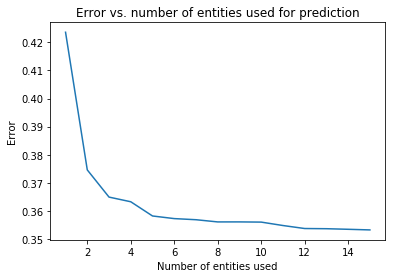

In [28]:
crowd_opt2.plot_crowd_error(X_test_red, y_test, rmse)

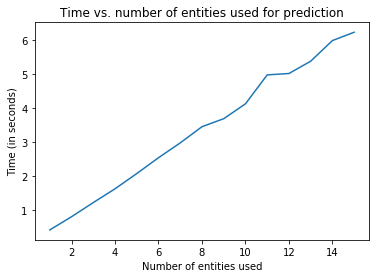

In [9]:
crowd_opt2.plot_crowd_pred_time(X_test_red)

In [8]:
start = timeit.default_timer()
pred = crowd_opt2.predict(X_test_red)
stop = timeit.default_timer()
error_rmse = rmse(pred, y_test)
print('Prediction time for {} samples : {} seconds\nRMSE : {} '.format(len(X_test_red), stop - start, error_rmse))

Prediction time for 7513 samples : 42.87941171799997 seconds
RMSE : 0.35298389679256353 


# Dropout & max-norm constraint

In [15]:
def cv_dropout_maxnorm(df_in, df_hidden, max_norm):
    model = tf.keras.Sequential()
    model.add(layers.Dropout(df_in))
    for i in range(8):
        model.add(layers.Dense(156, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(1e-6), \
                               kernel_constraint=MaxNorm(max_norm)))
        model.add(layers.Dropout(df_hidden))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)

    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 8s 391us/step - loss: 22.3194 - mean_absolute_error: 2.9690 - val_loss: 5.6041 - val_mean_absolute_error: 1.7566
Epoch 2/200
20282/20282 [==============================] - 5s 268us/step - loss: 4.8415 - mean_absolute_error: 1.6130 - val_loss: 3.1017 - val_mean_absolute_error: 1.2791
Epoch 3/200
20282/20282 [==============================] - 5s 246us/step - loss: 1.7316 - mean_absolute_error: 0.9382 - val_loss: 1.2099 - val_mean_absolute_error: 0.8174
Epoch 4/200
20282/20282 [==============================] - 5s 247us/step - loss: 0.5914 - mean_absolute_error: 0.5662 - val_loss: 0.7247 - val_mean_absolute_error: 0.5963
Epoch 5/200
20282/20282 [==============================] - 5s 245us/step - loss: 0.4205 - mean_absolute_error: 0.4795 - val_loss: 0.7767 - val_mean_absolute_error: 0.6629
Epoch 6/200
20282/20282 [==============================] - 5s 249us/step - loss: 0.3863 - mean_

20282/20282 [==============================] - 5s 243us/step - loss: 0.1765 - mean_absolute_error: 0.3040 - val_loss: 0.3359 - val_mean_absolute_error: 0.4139
Epoch 37/200
20282/20282 [==============================] - 5s 246us/step - loss: 0.1621 - mean_absolute_error: 0.2900 - val_loss: 0.3868 - val_mean_absolute_error: 0.4524
Epoch 38/200
20282/20282 [==============================] - 5s 259us/step - loss: 0.1863 - mean_absolute_error: 0.3128 - val_loss: 0.3506 - val_mean_absolute_error: 0.4055
Epoch 39/200
20282/20282 [==============================] - 5s 264us/step - loss: 0.2018 - mean_absolute_error: 0.3279 - val_loss: 0.4240 - val_mean_absolute_error: 0.4825
Epoch 40/200
20282/20282 [==============================] - 5s 264us/step - loss: 0.1903 - mean_absolute_error: 0.3156 - val_loss: 0.3243 - val_mean_absolute_error: 0.4010
Epoch 41/200
20282/20282 [==============================] - 5s 263us/step - loss: 0.1736 - mean_absolute_error: 0.3020 - val_loss: 0.4404 - val_mean_abso

Epoch 59/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.1247 - mean_absolute_error: 0.2517 - val_loss: 0.2940 - val_mean_absolute_error: 0.3887
Epoch 60/200
20282/20282 [==============================] - 7s 330us/step - loss: 0.1095 - mean_absolute_error: 0.2395 - val_loss: 0.2755 - val_mean_absolute_error: 0.3795
Epoch 61/200
20282/20282 [==============================] - 6s 318us/step - loss: 0.1241 - mean_absolute_error: 0.2523 - val_loss: 0.3032 - val_mean_absolute_error: 0.3738
Epoch 62/200
20282/20282 [==============================] - 6s 319us/step - loss: 0.1418 - mean_absolute_error: 0.2721 - val_loss: 0.3010 - val_mean_absolute_error: 0.3760
Epoch 63/200
20282/20282 [==============================] - 6s 303us/step - loss: 0.1239 - mean_absolute_error: 0.2536 - val_loss: 0.2612 - val_mean_absolute_error: 0.3501
Epoch 64/200
20282/20282 [==============================] - 6s 294us/step - loss: 0.1098 - mean_absolute_error: 0.2368 - val_loss: 0.2388 - 

20282/20282 [==============================] - 6s 279us/step - loss: 0.3921 - mean_absolute_error: 0.4623 - val_loss: 0.5527 - val_mean_absolute_error: 0.5196
Epoch 10/200
20282/20282 [==============================] - 6s 294us/step - loss: 0.3616 - mean_absolute_error: 0.4392 - val_loss: 0.4785 - val_mean_absolute_error: 0.4778
Epoch 11/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.3458 - mean_absolute_error: 0.4244 - val_loss: 0.4921 - val_mean_absolute_error: 0.4993
Epoch 12/200
20282/20282 [==============================] - 6s 282us/step - loss: 0.2993 - mean_absolute_error: 0.3989 - val_loss: 0.5489 - val_mean_absolute_error: 0.5526
Epoch 13/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.2975 - mean_absolute_error: 0.4002 - val_loss: 0.4619 - val_mean_absolute_error: 0.4985
Epoch 14/200
20282/20282 [==============================] - 6s 296us/step - loss: 0.2797 - mean_absolute_error: 0.3903 - val_loss: 0.3742 - val_mean_abso

Epoch 57/200
20282/20282 [==============================] - 5s 261us/step - loss: 0.1038 - mean_absolute_error: 0.2288 - val_loss: 0.2472 - val_mean_absolute_error: 0.3293
Epoch 58/200
20282/20282 [==============================] - 5s 260us/step - loss: 0.0894 - mean_absolute_error: 0.2146 - val_loss: 0.2435 - val_mean_absolute_error: 0.3374
Epoch 59/200
20282/20282 [==============================] - 5s 267us/step - loss: 0.0854 - mean_absolute_error: 0.2103 - val_loss: 0.2506 - val_mean_absolute_error: 0.3282
Epoch 60/200
20282/20282 [==============================] - 5s 267us/step - loss: 0.0871 - mean_absolute_error: 0.2098 - val_loss: 0.2385 - val_mean_absolute_error: 0.3276
Epoch 61/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.0771 - mean_absolute_error: 0.1980 - val_loss: 0.2691 - val_mean_absolute_error: 0.3644
Epoch 62/200
20282/20282 [==============================] - 5s 269us/step - loss: 0.0816 - mean_absolute_error: 0.2044 - val_loss: 0.2371 - 

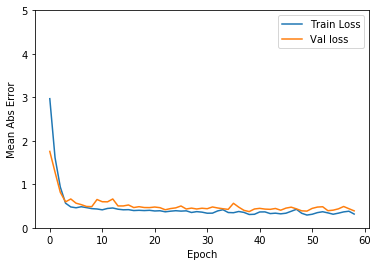

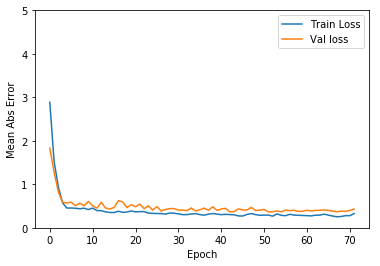

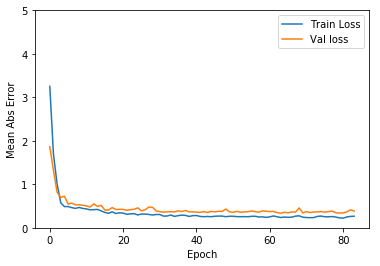

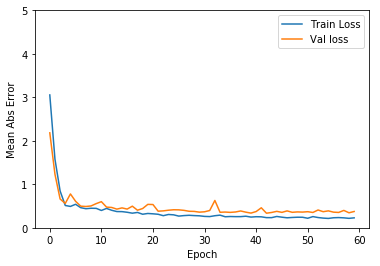

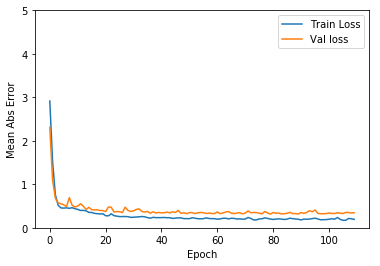

In [18]:
errors = []
for i in np.linspace(2, 4, 5):
    errors.append(cv_dropout_maxnorm(0.2, 0.5, i))

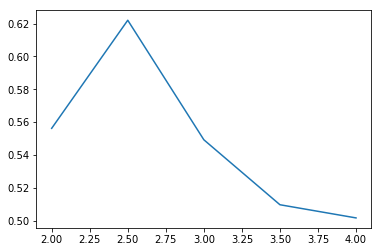

In [19]:
plt.plot(np.linspace(2, 4, 5), errors)

# Try k-fold only estimations

# Weights regularizers

# Try stacking

# Try reduce matrix with more features

Bigger networks enters under the spotlights.

In [5]:
X_pca_train = np.load(DATA_FOLDER + "x_pca_train.npy")[:, :-1]
y_pca_train = np.load(DATA_FOLDER + "y_pca_train.npy")
X_pca_test = np.load(DATA_FOLDER + "x_pca_test.npy")[:, :-1]
y_pca_test = np.load(DATA_FOLDER + "y_pca_test.npy")
X_pca_train.shape, X_pca_test.shape, y_pca_train.shape, y_pca_test.shape

((22536, 4500), (7513, 4500), (22536,), (7513,))

In [8]:
model = tf.keras.Sequential()
for i in range(8):
    model.add(layers.Dense(156, activation='relu', \
                           kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_pca_train, y_pca_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
plot_history(history)

result = model.predict(X_pca_test, batch_size=32)
error = rmse(result, y_pca_test)
print("Error : {}".format(error))

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 9s 432us/step - loss: 29.9325 - mean_absolute_error: 3.6331 - val_loss: 16.6040 - val_mean_absolute_error: 3.2118
Epoch 2/200
20282/20282 [==============================] - 8s 396us/step - loss: 2.1376 - mean_absolute_error: 1.0579 - val_loss: 8.9884 - val_mean_absolute_error: 2.2757
Epoch 3/200
20282/20282 [==============================] - 8s 397us/step - loss: 0.7239 - mean_absolute_error: 0.6215 - val_loss: 8.3732 - val_mean_absolute_error: 2.2331
Epoch 4/200
20282/20282 [==============================] - 8s 394us/step - loss: 0.5530 - mean_absolute_error: 0.5488 - val_loss: 6.6461 - val_mean_absolute_error: 1.9272
Epoch 5/200
20282/20282 [==============================] - 8s 404us/step - loss: 0.5993 - mean_absolute_error: 0.5670 - val_loss: 5.6034 - val_mean_absolute_error: 1.7639
Epoch 6/200
20282/20282 [==============================] - 8s 392us/step - loss: 0.7357 - mean

KeyboardInterrupt: 

## The bigger, the better

In [12]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
X_red.shape

(30049, 3004)

In [13]:
train_set_size = int(len(X_red) * TRAIN_SET_PERC)

# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 20s 1ms/step - loss: 23.1301 - mean_absolute_error: 2.8865 - val_loss: 2.7541 - val_mean_absolute_error: 1.2903
Epoch 2/200
20282/20282 [==============================] - 15s 734us/step - loss: 1.1507 - mean_absolute_error: 0.7784 - val_loss: 0.6975 - val_mean_absolute_error: 0.5890
Epoch 3/200
20282/20282 [==============================] - 14s 670us/step - loss: 0.4864 - mean_absolute_error: 0.5269 - val_loss: 0.7360 - val_mean_absolute_error: 0.6201
Epoch 4/200
20282/20282 [==============================] - 13s 633us/step - loss: 0.4372 - mean_absolute_error: 0.4988 - val_loss: 0.5303 - val_mean_absolute_error: 0.5168
Epoch 5/200
20282/20282 [==============================] - 13s 649us/step - loss: 0.4716 - mean_absolute_error: 0.5156 - val_loss: 1.2590 - val_mean_absolute_error: 0.8921
Epoch 6/200
20282/20282 [==============================] - 15s 733us/step - loss: 0.4728 - m

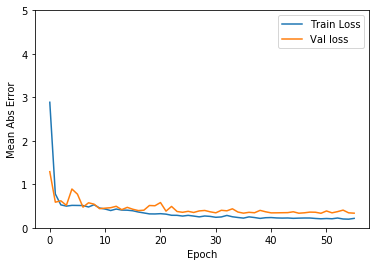

In [25]:
model = tf.keras.Sequential()
model.add(layers.Dropout(0.5))
for i in range(16):
    model.add(layers.Dense(256, activation='relu', \
                           kernel_regularizer=tf.keras.regularizers.l2(5e-6), \
                          kernel_constraint = MaxNorm(4)))
    model.add(layers.Dropout(0.5))
# Last layer represent the electromagnetic shielding, our prediction
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])
EPOCHS = 200
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
plot_history(history)

result = model.predict(X_test_red, batch_size=32)
error = rmse(result, y_test)
print("Error : {}".format(error))